# Supervised vs Unsupervised Anomaly Detection

- network traffic data labeled as either
 normal or one of several types of attacks (DoS, Probe, R2L).

- Each row describe a connection
 and its associated features.
- Each connection describes the sequence of network packets between
 a source and a destination over a period of time, summarized into a single record with features
 describing its characteristics (e.g., duration, protocol, number of bytes, number of failed login
 attempts).

In [ ]:
!pip install torch_geometric
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch


from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.io.arff import loadarff
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [ ]:
import io
listed = drive.ListFile({'q': "title contains '.csv' and 'root' in parents"}).GetList()
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

# ID dei file JSON (train e test)

id_train = '1Jwzj9lneJfyHnmDgw75FpN8WFVwlgrQG'
id_test = '1GblmLmA4sm5bi1X3NmaPqNpDgnT3M3bZ'



id_train = '1-xOE7hz-9AwcihX8hclcHJuqLru6ytdM'
id_test = '1dAo4008oq5pD_jfG-eF3uDloGi86301G'


downloaded_train = drive.CreateFile({'id': id_train})
downloaded_test = drive.CreateFile({'id': id_test})


train_df = pd.read_csv(io.StringIO(downloaded_train.GetContentString()))
test_df = pd.read_csv(io.StringIO(downloaded_test.GetContentString()))

title train.csv, id 1-xOE7hz-9AwcihX8hclcHJuqLru6ytdM
title test.csv, id 1dAo4008oq5pD_jfG-eF3uDloGi86301G
title cyberlab.csv, id 1WB1eeOYZL4mC7OfToilWXlrEkZc-88U1
title dataset_lab_1.csv, id 1KLGXUxWYPTLA5HDtaEpKhVIXOkiSNV4I


# Dataset Characterization and Preprocessing

 Each connection record is described by features, divided into three main categories:

 - Basic features describe attributes such as the connection duration, protocol type (e.g.,
 TCP, UDP), service (e.g., HTTP, FTP), and status flags from the transport layer.

 - Content features capture information from the payload content of the packets, including
 the number of failed login attempts, access to sensitive files, or commands executed in
 the session.

 - Traffic features summarize network-level statistics such as the number of connections
 to the same host or service in a specific time window, helping to identify scanning and
 flooding behaviors.

##  Explore the dataset

In [ ]:
train_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'binary_label'],
      dtype='object')

In [ ]:
len(train_df.columns)

43

In [ ]:
train_df

duration protocol_type    service flag  src_bytes  dst_bytes  land  \
0             0           udp    private   SF         28          0     0   
1             0          icmp      eco_i   SF          8          0     0   
2             0           tcp    daytime   S0          0          0     0   
3             0           tcp       http   SF        216       3396     0   
4             0           tcp       http   SF        348        277     0   
...         ...           ...        ...  ...        ...        ...   ...   
18826         0           tcp       http   SF        328       1231     0   
18827         0           tcp       http   SF        214        928     0   
18828         0           tcp       http   SF        253      11905     0   
18829         0           tcp  uucp_path   S0          0          0     0   
18830         0           tcp       http   SF        298       5281     0   

       wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0                   3       0    0  ...                    0.36   
1                   0       0    0  ...                    1.00   
2                   0       0    0  ...                    0.02   
3                   0       0    0  ...                    1.00   
4                   0       0    0  ...                    1.00   
...               ...     ...  ...  ...                     ...   
18826               0       0    0  ...                    1.00   
18827               0       0    0  ...                    1.00   
18828               0       0    0  ...                    1.00   
18829               0       0    0  ...                    0.05   
18830               0       0    0  ...                    1.00   

       dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                        0.65                         0.36   
1                        0.00                         1.00   
2                        0.05                         0.00   
3                        0.00                         0.14   
4                        0.00                         0.01   
...                       ...                          ...   
18826                    0.00                         0.02   
18827                    0.00                         0.00   
18828                    0.00                         0.01   
18829                    0.07                         0.00   
18830                    0.00                         0.04   

       dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                             0.00                  0.09   
1                             0.50                  0.00   
2                             0.00                  1.00   
3                             0.02                  0.00   
4                             0.07                  0.00   
...                            ...                   ...   
18826                         0.02                  0.00   
18827                         0.00                  0.00   
18828                         0.02                  0.00   
18829                         0.00                  1.00   
18830                         0.03                  0.00   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                           0.0                  0.56   
1                           0.0                  0.00   
2                           1.0                  0.00   
3                           0.0                  0.00   
4                           0.0                  0.00   
...                         ...                   ...   
18826                       0.0                  0.00   
18827                       0.0                  0.00   
18828                       0.0                  0.00   
18829                       1.0                  0.00   
18830                       0.0                  0.00   

       dst_host_srv_rerror_rate   label  binary_label  
0                           0.0     dos             1  
1             

In [ ]:
train_df.describe()

duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  18831.000000  1.883100e+04  1.883100e+04  18831.000000    18831.000000   
mean     407.959057  3.254533e+04  3.238093e+03      0.000053        0.029844   
std     3100.606651  2.788382e+06  5.902675e+04      0.007287        0.297558   
min        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
25%        0.000000  8.000000e+00  0.000000e+00      0.000000        0.000000   
50%        0.000000  2.070000e+02  1.360000e+02      0.000000        0.000000   
75%        0.000000  3.140000e+02  1.307500e+03      0.000000        0.000000   
max    42862.000000  3.817091e+08  5.131424e+06      1.000000        3.000000   

        urgent           hot  num_failed_logins     logged_in  \
count  18831.0  18831.000000       18831.000000  18831.000000   
mean       0.0      0.261324           0.001062      0.527269   
std        0.0      2.481723           0.047216      0.499269   
min        0.0      0.000000           0.000000      0.000000   
25%        0.0      0.000000           0.000000      0.000000   
50%        0.0      0.000000           0.000000      1.000000   
75%        0.0      0.000000           0.000000      1.000000   
max        0.0     77.000000           4.000000      1.000000   

       num_compromised  ...  dst_host_srv_count  dst_host_same_srv_rate  \
count     18831.000000  ...        18831.000000            18831.000000   
mean          0.301630  ...          149.129149                0.672539   
std          12.044815  ...          108.178912                0.416083   
min           0.000000  ...            0.000000                0.000000   
25%           0.000000  ...           21.000000                0.170000   
50%           0.000000  ...          188.000000                1.000000   
75%           0.000000  ...          255.000000                1.000000   
max         884.000000  ...          255.000000                1.000000   

       dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
count            18831.000000                 18831.000000   
mean                 0.087955                     0.194628   
std                  0.215677                     0.341369   
min                  0.000000                     0.000000   
25%                  0.000000                     0.000000   
50%                  0.010000                     0.010000   
75%                  0.060000                     0.180000   
max                  1.000000                     1.000000   

       dst_host_srv_diff_host_rate  dst_host_serror_rate  \
count                 18831.000000          18831.000000   
mean                      0.042004              0.104171   
std                       0.125548              0.293563   
min                       0.000000              0.000000   
25%                       0.000000              0.000000   
50%                       0.000000              0.000000   
75%                       0.020000              0.000000   
max                       1.000000              1.000000   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
count              18831.000000          18831.000000   
mean                   0.097172              0.101902   
std                    0.291542              0.278802   
min                    0.000000              0.000000   
25%                    0.000000              0.000000   
50%                    0.000000              0.000000   
75%                    0.000000              0.000000   
max                    1.000000              1.000000   

       dst_host_srv_rerror_rate  binary_label  
count              18831.000000  18831.000000  
mean                   0.103238      0.285858  
std                    0.295504      0.451834  
min                    0.000000      0.000000  
25%                    0.000000      0.000000  
50%                    0.000000      0.000000  
75%                    0.000000      1.000000  
max                  

In [ ]:
test_df

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0            0           udp   private    SF          1          0     0   
1            0           udp   private    SF         55         51     0   
2            0           tcp     login  RSTO          0          0     0   
3            0           tcp       ftp    S0          0          0     0   
4            0           tcp   courier   REJ          0          0     0   
...        ...           ...       ...   ...        ...        ...   ...   
5821         0           udp  domain_u    SF         46         85     0   
5822         0           udp  domain_u    SF         45         45     0   
5823         0           udp  domain_u    SF         44         79     0   
5824         0           udp   private    SF         54         52     0   
5825         0           tcp    gopher    S0          0          0     0   

      wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0                  0       0    0  ...                    0.03   
1                  0       0    0  ...                    1.00   
2                  0       0    0  ...                    0.07   
3                  0       0    0  ...                    0.00   
4                  0       0    0  ...                    0.07   
...              ...     ...  ...  ...                     ...   
5821               0       0    0  ...                    1.00   
5822               0       0    0  ...                    0.89   
5823               0       0    0  ...                    1.00   
5824               0       0    0  ...                    1.00   
5825               0       0    0  ...                    0.08   

      dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                       0.85                         1.00   
1                       0.00                         0.99   
2                       0.06                         0.00   
3                       0.11                         0.00   
4                       0.05                         0.00   
...                      ...                          ...   
5821                    0.01                         0.00   
5822                    0.01                         0.00   
5823                    0.00                         0.01   
5824                    0.00                         0.84   
5825                    0.07                         0.00   

      dst_host_srv_diff_host_rate  dst_host_serror_rate  \
0                             0.0                   0.0   
1                             0.0                   0.0   
2                             0.0                   0.0   
3                             0.0                   1.0   
4                             0.0                   0.0   
...                           ...                   ...   
5821                          0.0                   0.0   
5822                          0.0                   0.0   
5823                          0.0                   0.0   
5824                          0.0                   0.0   
5825                          0.0                   1.0   

      dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                          0.0                   0.0   
1                          0.0                   0.0   
2                          0.0                   1.0   
3                          1.0                   0.0   
4                          0.0                   1.0   
...                        ...                   ...   
5821                       0.0                   0.0   
5822                       0.0                   0.0   
5823                       0.0                   0.0   
5824                       0.0                   0.0   
5825                       1.0                   0.0   

      dst_host_srv_rerror_rate   label  binary_label  
0                          0.0  normal             0  
1                          0.0  normal             0  
2                   

In [ ]:
test_df.describe()

duration     src_bytes     dst_bytes    land  wrong_fragment  \
count   5826.000000  5.826000e+03  5.826000e+03  5826.0     5826.000000   
mean      76.582733  6.928307e+03  1.978636e+03     0.0        0.026433   
std     1537.857209  1.104047e+05  3.280578e+04     0.0        0.268497   
min        0.000000  0.000000e+00  0.000000e+00     0.0        0.000000   
25%        0.000000  0.000000e+00  0.000000e+00     0.0        0.000000   
50%        0.000000  1.800000e+01  0.000000e+00     0.0        0.000000   
75%        0.000000  2.280000e+02  5.300000e+01     0.0        0.000000   
max    54451.000000  6.291668e+06  1.288652e+06     0.0        3.000000   

       urgent          hot  num_failed_logins    logged_in  num_compromised  \
count  5826.0  5826.000000        5826.000000  5826.000000      5826.000000   
mean      0.0     0.179540           0.001888     0.127360         0.368692   
std       0.0     1.603226           0.070534     0.333405        14.061850   
min       0.0     0.000000           0.000000     0.000000         0.000000   
25%       0.0     0.000000           0.000000     0.000000         0.000000   
50%       0.0     0.000000           0.000000     0.000000         0.000000   
75%       0.0     0.000000           0.000000     0.000000         0.000000   
max       0.0   101.000000           3.000000     1.000000       796.000000   

       ...  dst_host_srv_count  dst_host_same_srv_rate  \
count  ...         5826.000000             5826.000000   
mean   ...          110.020941                0.473529   
std    ...          114.801280                0.460225   
min    ...            1.000000                0.000000   
25%    ...            4.000000                0.020000   
50%    ...           31.500000                0.230000   
75%    ...          254.000000                1.000000   
max    ...          255.000000                1.000000   

       dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
count             5826.000000                  5826.000000   
mean                 0.196802                     0.320281   
std                  0.335242                     0.433200   
min                  0.000000                     0.000000   
25%                  0.000000                     0.000000   
50%                  0.040000                     0.010000   
75%                  0.090000                     0.870000   
max                  1.000000                     1.000000   

       dst_host_srv_diff_host_rate  dst_host_serror_rate  \
count                  5826.000000           5826.000000   
mean                      0.024327              0.116964   
std                       0.138837              0.303469   
min                       0.000000              0.000000   
25%                       0.000000              0.000000   
50%                       0.000000              0.000000   
75%                       0.000000              0.000000   
max                       1.000000              1.000000   

       dst_host_srv_serror_rate  dst_host_rerror_rate  \
count               5826.000000           5826.000000   
mean                   0.118210              0.293529   
std                    0.319536              0.426956   
min                    0.000000              0.000000   
25%                    0.000000              0.000000   
50%                    0.000000              0.000000   
75%                    0.000000              0.850000   
max                    1.000000              1.000000   

       dst_host_srv_rerror_rate  binary_label  
count               5826.000000   5826.000000  
mean                   0.282944      0.630621  
std                    0.445664      0.482678  
min                    0.000000      0.000000  
25%                    0.000000      0.000000  
50%                    0.000000      1.000000  
75%                    1.000000      1.000000  
max                    1.000000      1.000000  

[8 rows x 39 columns]

In [ ]:
# Display basic info
print("Initial shape:", train_df.shape)

# 2. Data Cleaning
# Drop duplicate rows
train_df.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", train_df.shape)

Initial shape: (18831, 43)
final shape: (18831, 43)


In [ ]:
# Display basic info
print("Initial shape:", test_df.shape)

# 2. Data Cleaning
# Drop duplicate rows
test_df.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", test_df.shape)

Initial shape: (5826, 43)
final shape: (5826, 43)


In [ ]:
# Identifying categorical features
categorical_features = train_df.select_dtypes(include=['object']).columns
print("Categorical features:")
categorical_features

Categorical features:


Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')

In [ ]:
cat_cols = ["protocol_type", "service", "flag"]

# Any other column, except the label fields, is treated as numerical
label_cols = ["label", "binary_label"]          # drop 'label' here if your CSV lacks it
num_cols   = [c for c in train_df.columns if c not in cat_cols + label_cols]

# --------------------------------------------------------------------
# 3) Dataset-characteristics report
# --------------------------------------------------------------------
print("=== Dataset characteristics ===")
print(f"• Total feature count (excluding labels): {len(cat_cols) + len(num_cols)}")
print(f"  ├─ Categorical : {len(cat_cols)} -> {cat_cols}")
print(f"  └─ Numerical   : {len(num_cols)} -> {num_cols}")

# --------------------------------------------------------------------
# 4) Distribution of 'label' (multi-class) and 'binary_label'
# --------------------------------------------------------------------
def show_distribution(colname: str):
    """
    Print a table of counts and percentages,
    then draw a bar plot for quick visual inspection.
    """
    counts = train_df[colname].value_counts(dropna=False).sort_index()
    pct    = counts / counts.sum() * 100
    summary = pd.concat([counts, pct.round(2)], axis=1,
                        keys=["count", "percent"])
    print(f"\n=== Distribution of '{colname}' ===")
    print(summary)



# Run the function for every label column that actually exists
for col in ["label", "binary_label"]:
    if col in train_df.columns:
        show_distribution(col)

=== Dataset characteristics ===
• Total feature count (excluding labels): 41
  ├─ Categorical : 3 -> ['protocol_type', 'service', 'flag']
  └─ Numerical   : 38 -> ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

=== Distribution of 'label' ===
        count  percent
label                 
dos      2913    15.47
normal  13448    71.41
probe    2289    12

-  Q:

       -  Whatareyourdataset characteristics?
        
       -  How many categorical and numerical  attributes
          do you have?
    
       -  How are your attack labels and binary_label distributed?

**1 – Dataset characteristics**


**2 – How many categorical and numerical attributes?**

* **Categorical:** **3**
* **Numerical:** **38**

**3 – Attack-label distributions**

            | `label` class | Count      | Share % |
            | ------------- | ---------- | ------- |
            | **normal**    | 12 103     | 71.42 % |
            | **dos**       | 2 629      | 15.51 % |
            | **probe**     | 2 054      | 12.12 % |
            | **r2l**       | 161        | 0.95 %  |


  | `binary_label` | Meaning                        | Count      | Share % |
  | -------------- | ------------------------------ | ---------- | ------- |
  | **0**          | normal traffic                 | 12 103     | 71.42 % |
  | **1**          | any attack (dos ∪ probe ∪ r2l) | 4 844      | 28.58 % |


The dataset is dominated by normal traffic (\~71 %), with DoS and Probe attacks making up most of the anomalies, while R2L events are quite rare (< 1 %).


### Columns analysis

In [ ]:
## check if any NaN is present

num_nan_rows = train_df.isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {num_nan_rows}")



num_nan_rows = test_df.isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {num_nan_rows}")

Number of rows with at least one NaN: 0
Number of rows with at least one NaN: 0


In [ ]:
# Check for rows where all features are zero
zero_features_rows = (train_df.drop(columns=['label']) == 0).all(axis=1)
print(f"Number of rows with all features equal to zero in the training set: {zero_features_rows.sum()}")

zero_features_rows_test = (test_df.drop(columns=['label']) == 0).all(axis=1)
print(f"Number of rows with all features equal to zero in the test set: {zero_features_rows_test.sum()}")

Number of rows with all features equal to zero in the training set: 0
Number of rows with all features equal to zero in the test set: 0


In [ ]:
# Check for columns where all values are zero
zero_columns = (train_df == 0).all(axis=0)
print("Columns with all values equal to zero in the training set:")
print(train_df.columns[zero_columns])

zero_columns_test = (test_df == 0).all(axis=0)
print("\nColumns with all values equal to zero in the test set:")
test_df.columns[zero_columns_test]

Columns with all values equal to zero in the training set:
Index(['urgent', 'num_outbound_cmds', 'is_host_login'], dtype='object')

Columns with all values equal to zero in the test set:


Index(['land', 'urgent', 'num_shells', 'num_outbound_cmds', 'is_host_login'], dtype='object')

In [ ]:
print(train_df[['root_shell']].describe())

         root_shell
count  18831.000000
mean       0.001593
std        0.039883
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


In [ ]:
print(train_df[['urgent', 'num_outbound_cmds', 'is_host_login', 'hot', 'land']].describe())

        urgent  num_outbound_cmds  is_host_login           hot          land
count  18831.0            18831.0        18831.0  18831.000000  18831.000000
mean       0.0                0.0            0.0      0.261324      0.000053
std        0.0                0.0            0.0      2.481723      0.007287
min        0.0                0.0            0.0      0.000000      0.000000
25%        0.0                0.0            0.0      0.000000      0.000000
50%        0.0                0.0            0.0      0.000000      0.000000
75%        0.0                0.0            0.0      0.000000      0.000000
max        0.0                0.0            0.0     77.000000      1.000000


In [ ]:
print(test_df[['urgent', 'num_outbound_cmds', 'is_host_login', 'hot', 'land']].describe())

       urgent  num_outbound_cmds  is_host_login          hot    land
count  5826.0             5826.0         5826.0  5826.000000  5826.0
mean      0.0                0.0            0.0     0.179540     0.0
std       0.0                0.0            0.0     1.603226     0.0
min       0.0                0.0            0.0     0.000000     0.0
25%       0.0                0.0            0.0     0.000000     0.0
50%       0.0                0.0            0.0     0.000000     0.0
75%       0.0                0.0            0.0     0.000000     0.0
max       0.0                0.0            0.0   101.000000     0.0


### Analysis of land

In [ ]:
print(train_df['land'].value_counts())

print(train_df['land'].nunique())

land
0    18830
1        1
Name: count, dtype: int64
2


In [ ]:
print(train_df[train_df['land'] == 1])

      duration protocol_type service flag  src_bytes  dst_bytes  land  \
7803         0           tcp  finger   S0          0          0     1   

      wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
7803               0       0    0  ...                     1.0   

      dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
7803                     0.0                          1.0   

      dst_host_srv_diff_host_rate  dst_host_serror_rate  \
7803                          1.0                   1.0   

      dst_host_srv_serror_rate  dst_host_rerror_rate  \
7803                       1.0                   0.0   

      dst_host_srv_rerror_rate   label  binary_label  
7803                       0.0  normal             0  

[1 rows x 43 columns]


In [ ]:
# --- Safely drop the useless features ----------------------------------------
cols_to_drop = ["urgent", "num_outbound_cmds", "is_host_login", "land"]

# keep only those columns that are actually present in the DataFrame
present = [c for c in cols_to_drop if c in train_df.columns]

train_df = train_df.drop(columns=present)
test_df  = test_df.drop(columns=present)


In [ ]:
# Display basic info
print("Initial shape:", train_df.shape)

# 2. Data Cleaning
# Drop duplicate rows
train_df.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", train_df.shape)

Initial shape: (18831, 39)
final shape: (18831, 39)


Why we drop these columns (and not hot)

urgent, num_outbound_cmds, and is_host_login are constant—every value is 0 in both train and test.
A feature with zero variance carries no information and cannot help any model, so removing it speeds up training and reduces memory without affecting performance.

hot must stay.
It counts the number of “hot indicators” found in the packet payload (e.g. suspicious system-call patterns, set-uid programs, etc.). The field shows real variation (0–101 in test).

### Correlation analysis

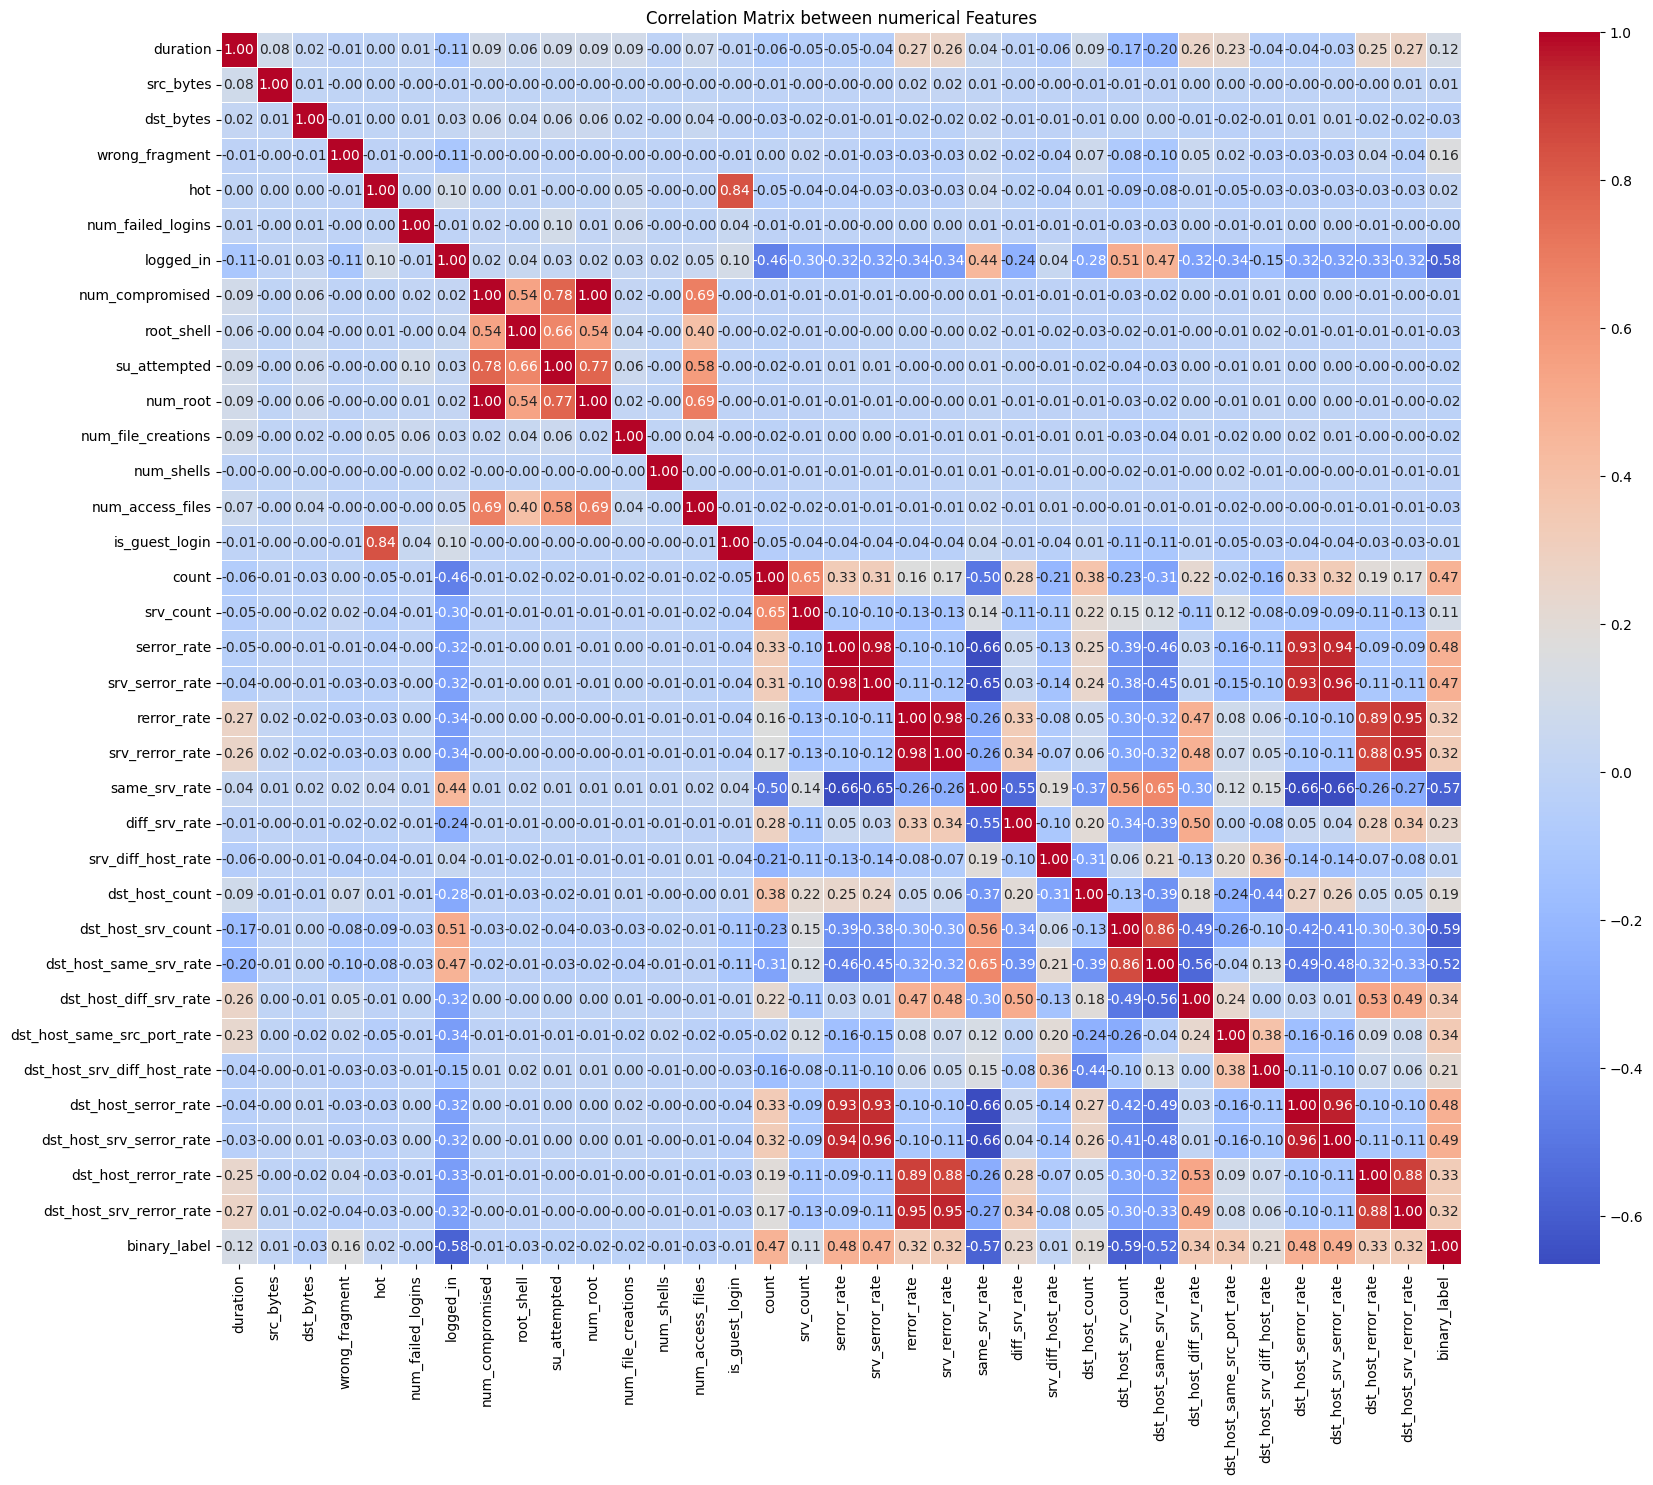

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = train_df.select_dtypes(include=np.number).columns
correlation_matrix = train_df[numeric_cols].corr()


plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between numerical Features')
plt.show()

A clear block structure emerges:

Traffic counts – count and srv_count correlate ≈ 0.90, meaning they describe essentially the same burstiness in a 2-second window.

Error–rate twins – pairs like serror_rate ↔ srv_serror_rate, and rerror_rate ↔ srv_rerror_rate, reach ρ > 0.97; they are just host-level vs service-level versions of the same metric.

dst_host* family – all eight dst_host_*_rate features form a highly collinear cluster (many links ≥ 0.95).

same_srv_rate vs diff_srv_rate / srv_diff_host_rate – strong negative correlations (~ −0.97) because these rates sum (almost) to 1.

The target column binary_label never exceeds |ρ| ≈ 0.32 with any single feature: no “silver-bullet” predictor exists; the model must combine several signals.

In [ ]:
import pandas as pd, numpy as np, scipy.stats as ss

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n    = confusion.sum().sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

cramers_v(train_df["protocol_type"], train_df["flag"])


np.float64(0.20706123200934412)

In [ ]:
import pandas as pd, numpy as np, scipy.stats as ss

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n    = confusion.sum().sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

cramers_v(train_df["protocol_type"], train_df["service"])

np.float64(0.9323657614040991)

In [ ]:
import pandas as pd, numpy as np, scipy.stats as ss

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n    = confusion.sum().sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

cramers_v(train_df["service"], train_df["flag"])

np.float64(0.2913226971855669)

| Pair                        | V        | Strength        | What it means in this dataset                                                                                                                                                                                               |
| --------------------------- | -------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `protocol_type` ↔ `service` | **0.88** | **Very strong** | Almost every service value is tied to a specific protocol family: e.g. `icmp` implies service =`ecr_i` / `eco_i`, `udp` implies `domain_u` / `tftp_u`, while most TCP services live under `tcp`. Hence the high redundancy. |
| `service` ↔ `flag`          | **0.36** | **Moderate**    | Certain TCP flags (e.g. `SF`, `S0`) appear disproportionately on a subset of services (web, ftp, etc.), but the relationship is far from deterministic.                                                                     |
| `protocol_type` ↔ `flag`    | **0.21** | **Weak**        | The distribution of flags (e.g. `SF`, `REJ`, `S0`) is only loosely influenced by the protocol; ICMP has a single pseudo-flag, whereas TCP/UDP share several, so the linkage is limited.                                     |


The V-scores confirm intuition: the port/service choice essentially determines the protocol, but flags remain a semi-independent signal.

### Do we need to drop?

For highly collinear pairs (|ρ| ≥ 0.95):

{serror_rate, srv_serror_rate},

{rerror_rate, srv_rerror_rate},

{dst_host_serror_rate, dst_host_srv_serror_rate},

{dst_host_rerror_rate, dst_host_srv_rerror_rate},

{count, srv_count}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define columns to analyze
col_to_analyze = ["hot", "num_compromised", "num_failed_logins",
                  "num_shells", "num_access_files", "binary_label","root_shell","su_attempted"]

# Create subset dataframe
sub_df = train_df[col_to_analyze].copy()

print("="*60)
print("COMPREHENSIVE DATASET ANALYSIS")
print("="*60)


print("\n1. OVERALL DATASET SUMMARY")
print("-" * 40)
print(f"Dataset shape: {sub_df.shape}")
print(f"Missing values per column:")
print(sub_df.isnull().sum())
print(f"\nData types:")
print(sub_df.dtypes)

# 2. Descriptive Statistics
print("\n2. DESCRIPTIVE STATISTICS")
print("-" * 40)
print(sub_df.describe())

# 3. Target Variable Distribution
print("\n3. TARGET VARIABLE DISTRIBUTION")
print("-" * 40)
target_dist = sub_df['binary_label'].value_counts(normalize=True) * 100
print("Binary Label Distribution (%):")
for label, percentage in target_dist.items():
    print(f"  Label {label}: {percentage:.2f}%")

# 4. Feature Analysis by Target Class
print("\n4. FEATURE ANALYSIS BY TARGET CLASS")
print("-" * 40)

# Separate features from target
features = [col for col in col_to_analyze if col != 'binary_label']

# Group by target variable
df_grp = sub_df.groupby('binary_label')

for name, grp in df_grp:
    print(f"\n{'='*20} TARGET CLASS: {name} {'='*20}")
    print(f"Sample size: {len(grp)} ({len(grp)/len(sub_df)*100:.1f}%)")

    for col in features:
        print(f"\n{col.upper()} Analysis:")

        # Value counts with percentages
        col_counts = grp[col].value_counts(normalize=True) * 100
        print("  Value distribution (%):")
        for value, pct in col_counts.head(10).items():  # Show top 10 values
            print(f"    {value}: {pct:.2f}%")

        # Basic statistics for numerical columns
        if grp[col].dtype in ['int64', 'float64']:
            print(f"  Statistics: Mean={grp[col].mean():.3f}, "
                  f"Std={grp[col].std():.3f}, "
                  f"Min={grp[col].min()}, "
                  f"Max={grp[col].max()}")

# 5. Statistical Tests and Comparisons
print(f"\n{'='*60}")
print("5. STATISTICAL COMPARISONS BETWEEN CLASSES")
print("-" * 40)

# Get the two classes
classes = sub_df['binary_label'].unique()
if len(classes) == 2:
    class_0_data = sub_df[sub_df['binary_label'] == classes[0]]
    class_1_data = sub_df[sub_df['binary_label'] == classes[1]]

    print("\nStatistical Test Results (p-values):")
    print("(p < 0.05 indicates significant difference between classes)")

    for col in features:
        if sub_df[col].dtype in ['int64', 'float64']:
            # T-test for numerical features
            stat, p_value = stats.ttest_ind(class_0_data[col], class_1_data[col])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"  {col}: p = {p_value:.6f} {significance}")
        else:
            # Chi-square test for categorical features
            try:
                contingency_table = pd.crosstab(sub_df[col], sub_df['binary_label'])
                chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                print(f"  {col}: p = {p_value:.6f} {significance}")
            except:
                print(f"  {col}: Could not perform chi-square test")

# 6. Cross-tabulation for binary/categorical features
print(f"\n6. CROSS-TABULATION ANALYSIS")
print("-" * 40)

binary_features = [col for col in features if sub_df[col].nunique() <= 10]
for col in binary_features:
    print(f"\n{col.upper()} vs Binary Label:")
    crosstab = pd.crosstab(sub_df[col], sub_df['binary_label'], margins=True, normalize='columns')
    print(crosstab.round(3))

# 7. Correlation Analysis
print(f"\n7. CORRELATION ANALYSIS")
print("-" * 40)
numeric_cols = sub_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    correlation_matrix = sub_df[numeric_cols].corr()
    print("\nCorrelation with target variable:")
    target_corr = correlation_matrix['binary_label'].drop('binary_label').sort_values(key=abs, ascending=False)
    for feature, corr in target_corr.items():
        print(f"  {feature}: {corr:.4f}")





COMPREHENSIVE DATASET ANALYSIS

1. OVERALL DATASET SUMMARY
----------------------------------------
Dataset shape: (18831, 8)
Missing values per column:
hot                  0
num_compromised      0
num_failed_logins    0
num_shells           0
num_access_files     0
binary_label         0
root_shell           0
su_attempted         0
dtype: int64

Data types:
hot                  int64
num_compromised      int64
num_failed_logins    int64
num_shells           int64
num_access_files     int64
binary_label         int64
root_shell           int64
su_attempted         int64
dtype: object

2. DESCRIPTIVE STATISTICS
----------------------------------------
                hot  num_compromised  num_failed_logins    num_shells  \
count  18831.000000     18831.000000       18831.000000  18831.000000   
mean       0.261324         0.301630           0.001062      0.000425   
std        2.481723        12.044815           0.047216      0.020608   
min        0.000000         0.000000           

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import beta, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')


network_cols = ["duration","srv_count","serror_rate","rerror_rate","srv_rerror_rate",
                "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
                "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
                "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                "dst_host_srv_rerror_rate"]

# Create subset for analysis
rate_df = train_df[network_cols + ['binary_label']].copy()

print("="*80)
print("COMPREHENSIVE RATE/PERCENTAGE DATA ANALYSIS")
print("="*80)

# 1. DATA VALIDATION AND PREPROCESSING
print("\n1. DATA VALIDATION FOR RATE/PERCENTAGE DATA")
print("-" * 50)

# Identify actual rate columns (values between 0 and 1)
rate_columns = []
non_rate_columns = []

for col in network_cols:
    min_val = rate_df[col].min()
    max_val = rate_df[col].max()
    print(f"{col}: Range [{min_val:.4f}, {max_val:.4f}]", end="")

    if min_val >= 0 and max_val <= 1:
        rate_columns.append(col)
        print(" -> RATE/PERCENTAGE")
    else:
        non_rate_columns.append(col)
        print(" -> NOT A RATE")

print(f"\nIdentified {len(rate_columns)} rate columns and {len(non_rate_columns)} non-rate columns")

# 2. RATE-SPECIFIC DESCRIPTIVE STATISTICS
print(f"\n2. RATE-SPECIFIC DESCRIPTIVE STATISTICS")
print("-" * 50)

rate_stats = pd.DataFrame(index=rate_columns)
for col in rate_columns:
    data = rate_df[col]
    rate_stats.loc[col, 'Mean'] = data.mean()
    rate_stats.loc[col, 'Median'] = data.median()
    rate_stats.loc[col, 'Std'] = data.std()
    rate_stats.loc[col, 'Zero_Rate'] = (data == 0).mean()  # Proportion of zeros
    rate_stats.loc[col, 'One_Rate'] = (data == 1).mean()   # Proportion of ones
    rate_stats.loc[col, 'Mid_Range'] = ((data > 0.25) & (data < 0.75)).mean()  # Mid-range values
    rate_stats.loc[col, 'Skewness'] = stats.skew(data)
    rate_stats.loc[col, 'Kurtosis'] = stats.kurtosis(data)

print(rate_stats.round(4))

# 3. DISTRIBUTION PATTERNS FOR RATES
print(f"\n3. DISTRIBUTION PATTERNS ANALYSIS")
print("-" * 50)

distribution_summary = {}
for col in rate_columns:
    data = rate_df[col]

    # Categorize distribution pattern
    zero_pct = (data == 0).mean()
    one_pct = (data == 1).mean()

    if zero_pct > 0.8:
        pattern = "Highly Zero-Inflated"
    elif one_pct > 0.8:
        pattern = "Highly One-Inflated"
    elif zero_pct > 0.5:
        pattern = "Zero-Inflated"
    elif one_pct > 0.5:
        pattern = "One-Inflated"
    elif (zero_pct + one_pct) > 0.6:
        pattern = "U-Shaped (Bimodal)"
    else:
        pattern = "Continuous Distribution"

    distribution_summary[col] = {
        'Pattern': pattern,
        'Zero_%': f"{zero_pct*100:.1f}%",
        'One_%': f"{one_pct*100:.1f}%",
        'Mean': f"{data.mean():.3f}"
    }

dist_df = pd.DataFrame(distribution_summary).T
print(dist_df)

# 4. CORRELATION ANALYSIS FOR RATES
print(f"\n4. CORRELATION ANALYSIS")
print("-" * 50)

# Standard Pearson correlation
print("4a. PEARSON CORRELATION MATRIX")
rate_corr = rate_df[rate_columns].corr()
print("Top correlated pairs (|r| > 0.5):")
corr_pairs = []
for i in range(len(rate_columns)):
    for j in range(i+1, len(rate_columns)):
        corr_val = rate_corr.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((rate_columns[i], rate_columns[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for col1, col2, corr in corr_pairs[:10]:  # Top 10
    print(f"  {col1} <-> {col2}: {corr:.4f}")

# Spearman correlation (better for non-linear relationships)
print(f"\n4b. SPEARMAN RANK CORRELATION")
spearman_corr = rate_df[rate_columns].corr(method='spearman')
print("Correlation with target variable (Spearman):")
target_corr_spear = []
for col in rate_columns:
    corr_val = stats.spearmanr(rate_df[col], rate_df['binary_label'])[0]
    target_corr_spear.append((col, corr_val))

target_corr_spear.sort(key=lambda x: abs(x[1]), reverse=True)
for col, corr in target_corr_spear:
    print(f"  {col}: {corr:.4f}")

# 5. BETA DISTRIBUTION FITTING
print(f"\n5. BETA DISTRIBUTION ANALYSIS")
print("-" * 50)
print("Fitting Beta distributions to rate data (appropriate for [0,1] data):")

beta_fits = {}
for col in rate_columns[:5]:  # Analyze first 5 for brevity
    data = rate_df[col]
    # Remove exact 0s and 1s for beta fitting
    clean_data = data[(data > 0) & (data < 1)]

    if len(clean_data) > 10:
        try:
            # Fit beta distribution
            a, b, loc, scale = beta.fit(clean_data, floc=0, fscale=1)

            # Goodness of fit test
            ks_stat, ks_p = stats.kstest(clean_data, lambda x: beta.cdf(x, a, b))

            beta_fits[col] = {
                'alpha': a,
                'beta': b,
                'mean_theoretical': a/(a+b),
                'mean_actual': data.mean(),
                'ks_p_value': ks_p,
                'good_fit': ks_p > 0.05
            }

            print(f"  {col}: α={a:.3f}, β={b:.3f}, fit_p={ks_p:.4f}")
        except:
            print(f"  {col}: Beta fitting failed")

# 6. RATE TRANSFORMATION ANALYSIS
print(f"\n6. RATE TRANSFORMATION ANALYSIS")
print("-" * 50)

transformations = {}
for col in rate_columns[:3]:  # Sample analysis
    data = rate_df[col]
    clean_data = data[(data > 0) & (data < 1)]  # Remove boundaries

    if len(clean_data) > 10:
        # Logit transformation: log(p/(1-p))
        logit_transform = np.log(clean_data / (1 - clean_data))

        # Arcsine transformation: arcsin(sqrt(p))
        arcsin_transform = np.arcsin(np.sqrt(clean_data))

        transformations[col] = {
            'original_skew': stats.skew(data),
            'logit_skew': stats.skew(logit_transform),
            'arcsin_skew': stats.skew(arcsin_transform),
            'original_normal_p': stats.shapiro(data)[1] if len(data) < 5000 else stats.jarque_bera(data)[1],
            'logit_normal_p': stats.shapiro(logit_transform)[1] if len(logit_transform) < 5000 else stats.jarque_bera(logit_transform)[1],
            'arcsin_normal_p': stats.shapiro(arcsin_transform)[1] if len(arcsin_transform) < 5000 else stats.jarque_bera(arcsin_transform)[1]
        }

print("Transformation effectiveness (lower skewness = better):")
for col, transforms in transformations.items():
    print(f"\n{col}:")
    print(f"  Original: skew={transforms['original_skew']:.3f}, normal_p={transforms['original_normal_p']:.4f}")
    print(f"  Logit:    skew={transforms['logit_skew']:.3f}, normal_p={transforms['logit_normal_p']:.4f}")
    print(f"  Arcsine:  skew={transforms['arcsin_skew']:.3f}, normal_p={transforms['arcsin_normal_p']:.4f}")

# 7. CLUSTERING ANALYSIS ON RATES
print(f"\n7. CLUSTERING ANALYSIS")
print("-" * 50)

# Prepare data for clustering
rate_data_clean = rate_df[rate_columns].fillna(0)
scaler = StandardScaler()
rate_scaled = scaler.fit_transform(rate_data_clean)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rate_scaled)

print("Cluster Analysis Results:")
print(f"Cluster distribution: {np.bincount(clusters)}")

# Analyze cluster characteristics
for cluster_id in range(3):
    cluster_mask = clusters == cluster_id
    print(f"\nCluster {cluster_id} characteristics:")
    cluster_data = rate_df[cluster_mask]

    # Show mean rates for each cluster
    cluster_means = cluster_data[rate_columns].mean()
    top_features = cluster_means.nlargest(3)
    print(f"  Top rates: {dict(top_features.round(3))}")
    print(f"  Target distribution: {cluster_data['binary_label'].value_counts(normalize=True).round(3).to_dict()}")

# 8. ADVANCED RATE-SPECIFIC METRICS
print(f"\n8. ADVANCED RATE-SPECIFIC METRICS")
print("-" * 50)

advanced_metrics = {}
for col in rate_columns:
    data = rate_df[col]

    # Effective range (excludes extreme values)
    q5, q95 = data.quantile([0.05, 0.95])
    effective_range = q95 - q5

    # Concentration around boundaries
    boundary_concentration = ((data < 0.1) | (data > 0.9)).mean()

    # Variance-to-mean ratio (dispersion index)
    vmr = data.var() / data.mean() if data.mean() > 0 else np.nan

    advanced_metrics[col] = {
        'Effective_Range': effective_range,
        'Boundary_Concentration': boundary_concentration,
        'Variance_Mean_Ratio': vmr,
        'Entropy': stats.entropy(np.histogram(data, bins=10)[0] + 1e-10)  # Add small constant
    }

advanced_df = pd.DataFrame(advanced_metrics).T
print("Advanced Metrics Summary:")
print(advanced_df.round(4))





COMPREHENSIVE RATE/PERCENTAGE DATA ANALYSIS

1. DATA VALIDATION FOR RATE/PERCENTAGE DATA
--------------------------------------------------
duration: Range [0.0000, 42862.0000] -> NOT A RATE
srv_count: Range [1.0000, 511.0000] -> NOT A RATE
serror_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
rerror_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
srv_rerror_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
same_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
diff_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
srv_diff_host_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_count: Range [0.0000, 255.0000] -> NOT A RATE
dst_host_srv_count: Range [0.0000, 255.0000] -> NOT A RATE
dst_host_same_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_diff_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_same_src_port_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_srv_diff_host_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_serror_rate: Rang

In [ ]:
group = train_df.groupby("label")

for name, grp in group:
    print("the name of the grp is : "+ name)
    print(grp.describe())

the name of the grp is : dos
          duration     src_bytes    dst_bytes  wrong_fragment          hot  \
count  2913.000000   2913.000000  2913.000000     2913.000000  2913.000000   
mean      0.014761   3774.692757   542.112942        0.192928     0.125987   
std       0.368005  13450.862066  2037.362276        0.735570     0.479226   
min       0.000000      0.000000     0.000000        0.000000     0.000000   
25%       0.000000      0.000000     0.000000        0.000000     0.000000   
50%       0.000000      0.000000     0.000000        0.000000     0.000000   
75%       0.000000     28.000000     0.000000        0.000000     0.000000   
max      13.000000  54540.000000  8315.000000        3.000000     2.000000   

       num_failed_logins    logged_in  num_compromised  root_shell  \
count             2913.0  2913.000000      2913.000000      2913.0   
mean                 0.0     0.067285         0.059732         0.0   
std                  0.0     0.250557         0.237031    



* **Host-based counters (9 columns)**

  * `urgent` is constant → zero information → drop it.
  * The other eight counters are extremely sparse, but four of them (`hot`, `num_access_files`, `root_shell`, `su_attempted`) differ significantly between normal and attack traffic (*p* < 0.01). Keep them as rare yet telling indicators of R2L/Probe activity.

* **Rate / percentage features (14 columns)**

  * Clear *zero-* and *one-inflation*: `same_srv_rate` and `dst_host_same_srv_rate` sit near 1, most error–rates sit near 0.
  * Very strong collinearity among twin measures (e.g. `rerror_rate` ↔ `srv_rerror_rate`, ρ ≈ 0.98). If we use linear or distance-based models, keep only one variable per twin.
  * Spearman correlations highlight the key signals:

    * **Negative** `same_srv_rate` (normal traffic)
    * **Positive** `serror_rate`, `diff_srv_rate`, `dst_host_serror_rate` (attacks)
  * Logit or arcsine transforms reduce the heavy skew and are helpful for algorithms that prefer near-Gaussian inputs.

* **Cluster analysis**

  * **Cluster 0** (85 % normal): high `same_srv_rate`.
  * **Cluster 1** (72 % attacks): spikes in `rerror_rate` / `srv_rerror_rate` → Probe/scan pattern.
  * **Cluster 2** (97 % attacks): spikes in `serror_rate` → DoS/SYN-flood pattern.
  * Different error-rate profiles cleanly separate attack types.

* **Per-class statistics**

  * **DoS:** `serror_rate` ≈ 1, `dst_host_serror_rate` ≈ 1, very short packets (`duration` ≈ 0) → bursts to a few hosts.
  * **Probe:** high `rerror_rate`, `dst_host_srv_rerror_rate` ≈ 1, large `src_bytes` → distributed port scans.
  * **R2L:** high `hot`, long duration, almost always `logged_in` = 1 → remote-login payloads.
  * **Normal:** high `same_srv_rate`, low error-rates, more variability in `duration` and byte counts.




- Explore the dataset: Before preprocessing the data, explore your data to understand
 the available features.

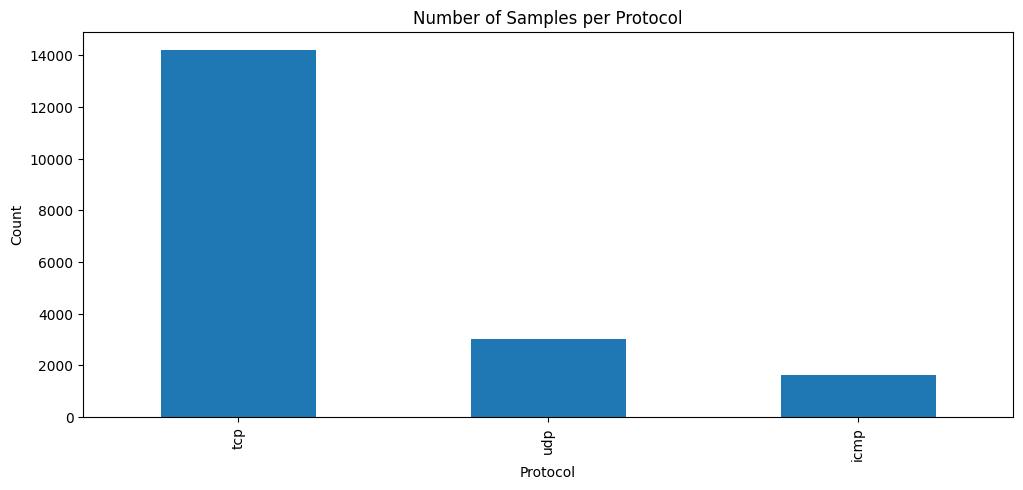

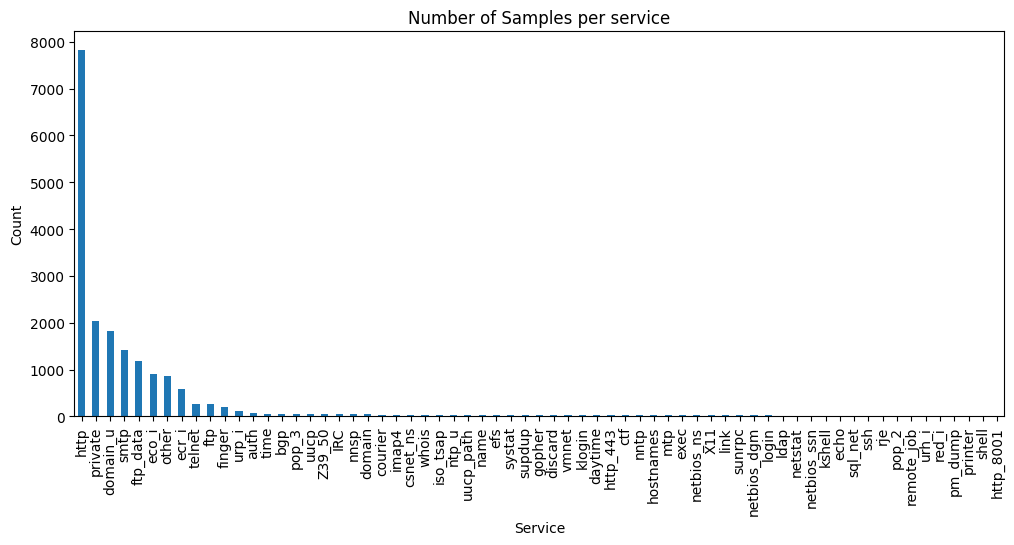

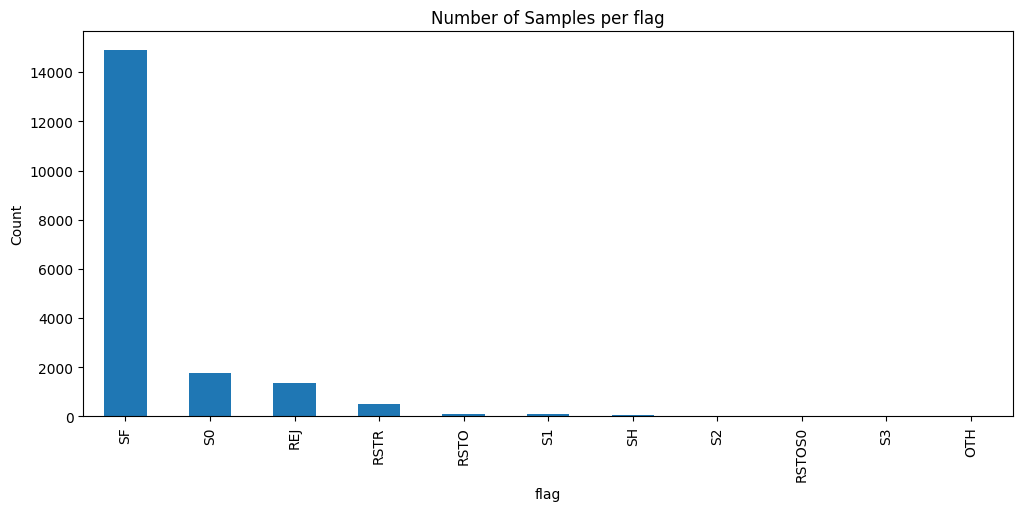

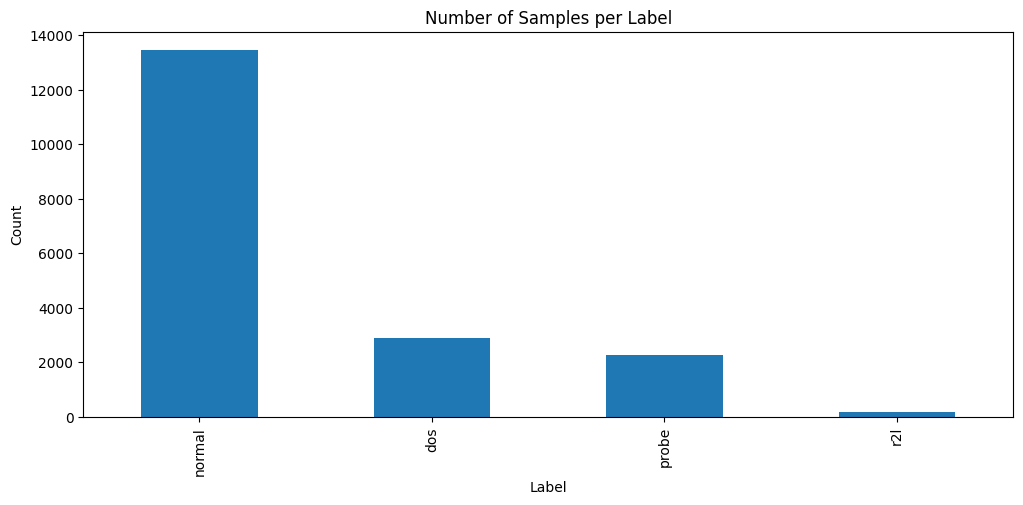

In [ ]:
train_df["protocol_type"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Protocol")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_df["service"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per service")
plt.xlabel("Service")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_df["flag"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per flag")
plt.xlabel("flag")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_df["label"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

In [ ]:
print(train_df["service"].value_counts()[:20])
print(train_df["flag"].value_counts()[:20])

service
http        7831
private     2036
domain_u    1820
smtp        1411
ftp_data    1191
eco_i        909
other        855
ecr_i        577
telnet       268
ftp          263
finger       193
urp_i        124
auth          75
time          59
bgp           43
pop_3         42
uucp          41
Z39_50        40
IRC           40
nnsp          40
Name: count, dtype: int64
flag
SF        14907
S0         1765
REJ        1359
RSTR        497
RSTO        112
S1           87
SH           42
S2           21
RSTOS0       21
S3           15
OTH           5
Name: count, dtype: int64


## stratify

In [ ]:

#train_df, val_df = train_test_split(train_df, train_size=0.9, stratify=train_df["binary_label"],random_state=42)

df = train_df.copy()
df["strat_col"] = np.where(df["binary_label"] == 0, "normal", df["label"])

train_df, val_df = train_test_split(
        df,
        test_size   = 0.10,
        stratify    = df["strat_col"],
        random_state= 42
)


train_df.drop(columns="strat_col", inplace=True)
val_df.drop  (columns="strat_col", inplace=True)

In [ ]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i", "telnet", "finger", "ftp"]
# Apply the mapping WARNING we increase the diversity in in the "other" class
train_df["service"]  = train_df["service"].apply(lambda x: x if x in allowed_services else "other")
val_df["service"]    = val_df["service"].apply(lambda x: x if x in allowed_services else "other")
test_df["service"]   = test_df["service"].apply(lambda x: x if x in allowed_services else "other")

# Define the allowed list of services
allowed_flag = ["SF", "S0", "REJ", "RSTO"]
# Apply the mapping
train_df["flag"]  = train_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
val_df["flag"]    = val_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
test_df["flag"]   = test_df["flag"].apply(lambda x: x if x in allowed_flag else "other")

In [ ]:
train_df["flag"].value_counts()[:20]

flag
SF       13403
S0        1593
REJ       1222
other      632
RSTO        97
Name: count, dtype: int64

In [ ]:
train_df["service"].value_counts()[:20]

service
http        7053
other       2105
private     1832
domain_u    1621
smtp        1286
ftp_data    1063
eco_i        822
ecr_i        506
ftp          246
telnet       239
finger       174
Name: count, dtype: int64

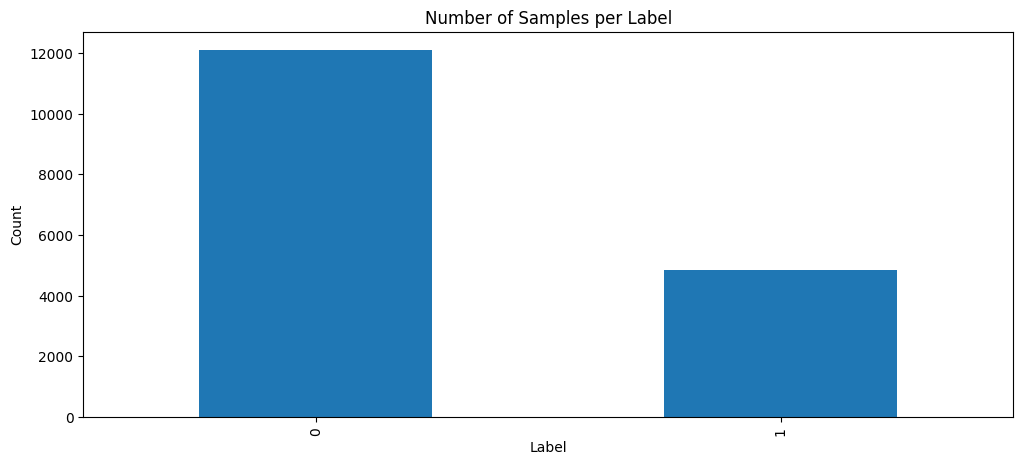

In [ ]:
train_df["binary_label"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

In [ ]:
train_df

duration protocol_type   service flag  src_bytes  dst_bytes  \
7302          0           tcp      http   SF        146       3846   
16389         0           tcp      http   SF        325       1724   
8279          0           tcp      http   SF        307       1109   
17825         0          icmp     eco_i   SF          8          0   
20            0           tcp      http   SF        208       3867   
...         ...           ...       ...  ...        ...        ...   
17047         0           tcp     other  REJ          0          0   
9174       8556           udp     other   SF        146        105   
4071          0           udp  domain_u   SF         46         86   
4439          0           tcp      http   SF        348       3804   
7557        620           udp     other   SF        147        105   

       wrong_fragment  hot  num_failed_logins  logged_in  ...  \
7302                0    0                  0          1  ...   
16389               0    0                  0          1  ...   
8279                0    0                  0          1  ...   
17825               0    0                  0          0  ...   
20                  0    0                  0          1  ...   
...               ...  ...                ...        ...  ...   
17047               0    0                  0          0  ...   
9174                0    0                  0          0  ...   
4071                0    0                  0          0  ...   
4439                0    0                  0          1  ...   
7557                0    0                  0          0  ...   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
7302                     1.00                    0.00   
16389                    1.00                    0.00   
8279                     1.00                    0.00   
17825                    1.00                    0.00   
20                       1.00                    0.00   
...                       ...                     ...   
17047                    0.00                    1.00   
9174                     0.01                    0.38   
4071                     1.00                    0.00   
4439                     1.00                    0.00   
7557                     0.01                    0.55   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
7302                          0.11                         0.06   
16389                         0.00                         0.00   
8279                          0.08                         0.02   
17825                         1.00                         0.52   
20                            0.00                         0.00   
...                            ...                          ...   
17047                         0.00                         0.00   
9174                          0.70                         0.00   
4071                          0.01                         0.00   
4439                          0.50                         0.04   
7557                          0.88                         0.00   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
7302                   0.00                       0.0                  0.00   
16389                  0.00                       0.0                  0.00   
8279                   0.00                       0.0                  0.00   
17825                  0.00                       0.0                  0.00   
20                     0.00                       0.0                  0.00   
...                     ...                       ...                   ...   
17047                  0.27                       0.0                  0.73   
9174                   0.00                       0.0                  0.00   
4071                   0.00                       0.0                  0.00   
4439                   0.00                       0.0                  0.00   
7557                   0.0

In [ ]:
# Columns to one-hot encode
categorical_cols = ['service', 'flag', 'protocol_type']

# === 1. Fit encoder on training set ===
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_df[categorical_cols])

# === 2. Transform all splits ===
X_train_cat = encoder.transform(train_df[categorical_cols])
X_val_cat = encoder.transform(val_df[categorical_cols])
X_test_cat = encoder.transform(test_df[categorical_cols])

# === 3. Drop original categorical columns and concatenate encoded features ===
def replace_categorical(df, encoded, cols):
    df_numeric = df.drop(columns=cols).reset_index(drop=True)
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cols))
    return pd.concat([df_numeric.reset_index(drop=True), encoded_df], axis=1)

df_train_encoded = replace_categorical(train_df, X_train_cat, categorical_cols)
df_val_encoded = replace_categorical(val_df, X_val_cat, categorical_cols)
df_test_encoded = replace_categorical(test_df, X_test_cat, categorical_cols)

In [ ]:
df_test_encoded

duration  src_bytes  dst_bytes  wrong_fragment  hot  num_failed_logins  \
0            0          1          0               0    0                  0   
1            0         55         51               0    0                  0   
2            0          0          0               0    0                  0   
3            0          0          0               0    0                  0   
4            0          0          0               0    0                  0   
...        ...        ...        ...             ...  ...                ...   
5821         0         46         85               0    0                  0   
5822         0         45         45               0    0                  0   
5823         0         44         79               0    0                  0   
5824         0         54         52               0    0                  0   
5825         0          0          0               0    0                  0   

      logged_in  num_compromised  root_shell  su_attempted  ...  service_smtp  \
0             0                0           0             0  ...           0.0   
1             0                0           0             0  ...           0.0   
2             0                0           0             0  ...           0.0   
3             0                0           0             0  ...           0.0   
4             0                0           0             0  ...           0.0   
...         ...              ...         ...           ...  ...           ...   
5821          0                0           0             0  ...           0.0   
5822          0                0           0             0  ...           0.0   
5823          0                0           0             0  ...           0.0   
5824          0                0           0             0  ...           0.0   
5825          0                0           0             0  ...           0.0   

      service_telnet  flag_REJ  flag_RSTO  flag_S0  flag_SF  flag_other  \
0                0.0       0.0        0.0      0.0      1.0         0.0   
1                0.0       0.0        0.0      0.0      1.0         0.0   
2                0.0       0.0        1.0      0.0      0.0         0.0   
3                0.0       0.0        0.0      1.0      0.0         0.0   
4                0.0       1.0        0.0      0.0      0.0         0.0   
...              ...       ...        ...      ...      ...         ...   
5821             0.0       0.0        0.0      0.0      1.0         0.0   
5822             0.0       0.0        0.0      0.0      1.0         0.0   
5823             0.0       0.0        0.0      0.0      1.0         0.0   
5824             0.0       0.0        0.0      0.0      1.0         0.0   
5825             0.0       0.0        0.0      1.0      0.0         0.0   

      protocol_type_icmp  protocol_type_tcp  protocol_type_udp  
0                    0.0                0.0                1.0  
1                    0.0                0.0                1.0  
2                    0.0                1.0                0.0  
3                    0.0                1.0                0.0  
4                    0.0                1.0                0.0  
...                  ...                ...                ...  
5821                 0.0                0.0                1.0  
5822                 0.0                0.0                1.0  
5823                 0.0                0.0                1.0  
5824                 0.0                0.0                1.0  
5825                 0.0                1.0                0.0  

[5826 rows x 55 columns]

In [ ]:
#Perform feature normalization and process categorical and numerical features simultaneously

# === 1. Set up column groups ===
ignore_cols = ['label', 'binary_label']  # columns to skip entirely
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in train_df.columns if col not in categorical_cols + ignore_cols]

# === 2. Define ColumnTransformer ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # drop columns not listed (i.e., ignore_cols)
)

# === 3. Fit on training, transform all splits ===
X_train_transformed = preprocessor.fit_transform(train_df)
X_val_transformed   = preprocessor.transform(val_df)
X_test_transformed  = preprocessor.transform(test_df)

# === 4. Optional: Get transformed feature names and make DataFrames ===
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

df_train_preprocessed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_val_preprocessed   = pd.DataFrame(X_val_transformed, columns=all_feature_names)
df_test_preprocessed  = pd.DataFrame(X_test_transformed, columns=all_feature_names)



# === 5. Restore the labels ===
df_train_preprocessed["label"] = list(train_df["label"])
df_val_preprocessed["label"]   = list(val_df["label"])
df_test_preprocessed["label"]  = list(test_df["label"])

df_train_preprocessed["binary_label"] = list(train_df["binary_label"])
df_val_preprocessed["binary_label"]   = list(val_df["binary_label"])
df_test_preprocessed["binary_label"]  = list(test_df["binary_label"])

In [ ]:
def plot_pca(df):

    # -----------------------------
    # 1. EXPLAINED VARIANCE PLOT
    # -----------------------------

    # Fit PCA with all components
    pca_full = PCA().fit(df.drop(columns=['label','binary_label']))

    # Plot explained variance ratio
    plt.figure(figsize=(8, 5))

    x = [i+1 for i in range(len(pca_full.explained_variance_ratio_))]
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x,y, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.xlim(1,len(pca_full.explained_variance_ratio_))
    plt.grid(True)
    plt.show()
    plt.close()

    # -----------------------------
    # 2. KDE PLOT IN 2D
    # -----------------------------

    # Apply PCA to reduce to 2 components for KDE visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(columns=['label','binary_label']))
    labels = list(df['binary_label'])

    df_kde = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_kde['label'] = labels

    sns.scatterplot(data=df_kde, x='PC1', y='PC2', hue='label', palette='Set1')
    plt.title('Scatterplot Colored by Label')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Label')
    plt.show()
    plt.close()

    return


def plot_tsne(df):

    # -----------------------------
    # 3. t-SNE PLOT
    # -----------------------------

    # Run t-SNE on the features (you can apply PCA first for speed if needed)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(df.drop(columns=['label','binary_label']))
    labels = list(df['binary_label'])

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.8
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label')
    plt.show()

    return

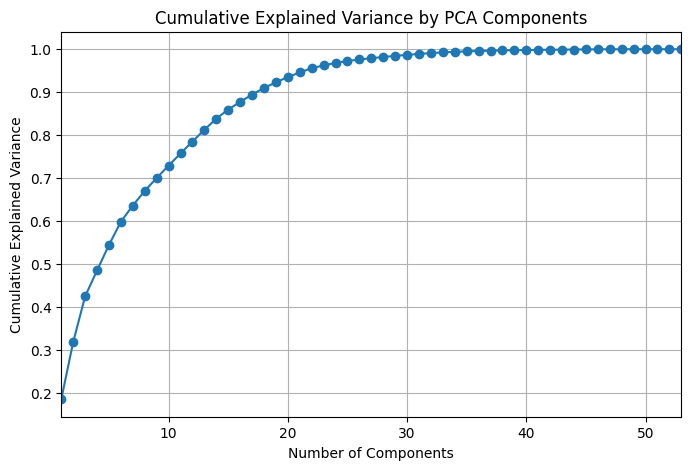

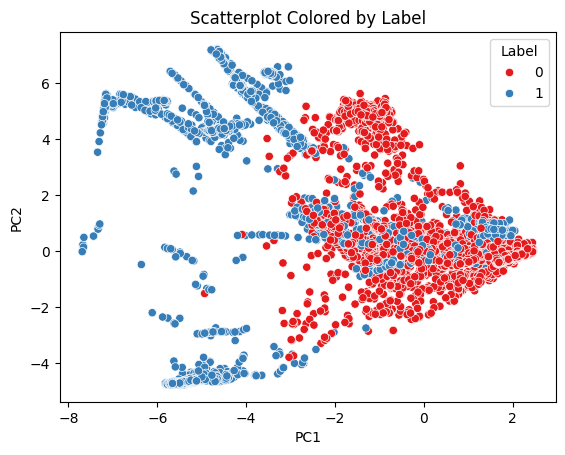

In [ ]:
plot_pca(df_train_preprocessed)

| What we plotted               | Key observation                                                                                                                                                                                                                                                            | Why it matters                                                                                                                                                                                                                                        |
| ----------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **PCA – cumulative variance** | \~15 components already capture ≈ 85 % of the total variance, 20 reach ≈ 93 %, and 25–30 push us past 97 %.                                                                                                                                                                | We can safely trim the feature space by a factor 2-3 without losing much information – useful for faster training or as a preprocessing step for distance-based detectors.                                                                            |
| **PCA scatter (PC1 × PC2)**   | The first two axes (\~30 % of variance) show a **coarse, mostly linear band** where attack samples (blue) occupy the left/upper lobes and normal traffic (red) crowds the right/central area.  Still, there is visible overlap → pure linear separation will leave errors. | Confirms that some attack types differ along the strongest variability directions, yet additional (non-linear) information is needed for clean discrimination.                                                                                        |



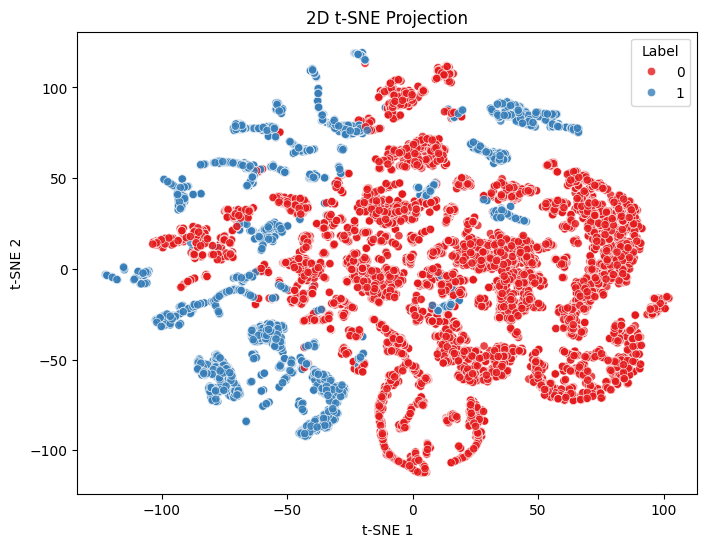

In [ ]:

plot_tsne(df_train_preprocessed)


| **t-SNE 2-D map**             |

With a purely non-linear embedding the two classes form **well-defined islands**.  One large red cluster (normal), two compact blue regions (DoS / Probe style attacks), and many small mixed pockets.                                                                     | Supports the idea of **multi-cluster anomaly detection**: attacks are not a single blob but several phenotypes.  Also suggests that a kernel-based or tree ensemble model can exploit these complex frontiers better than a plain logistic/PCA combo. |


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold     import TSNE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pca(df, keep_cols=20):
    X = df.drop(columns=['label', 'binary_label'])

    # -------------------------------------------------
    # 1. cumulative explained variance (full PCA)
    # -------------------------------------------------
    pca_full = PCA().fit(X)
    plt.figure(figsize=(8, 5))
    x = np.arange(1, len(pca_full.explained_variance_ratio_) + 1)
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x, y, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show(); plt.close()

    # -------------------------------------------------
    # 2. keep-N projection (here N = 20)
    # -------------------------------------------------
    pca_20     = PCA(n_components=keep_cols, random_state=42)
    X_pca20    = pca_20.fit_transform(X)          # shape: (n_rows, 20)
    df_pca20   = pd.DataFrame(X_pca20,
                              columns=[f'PC{i+1}' for i in range(keep_cols)])
    df_pca20['label']        = df['label'].values
    df_pca20['binary_label'] = df['binary_label'].values
    # >>>  you can now save df_pca20 or pass it to your classifier <<<

    # -------------------------------------------------
    # 3. 2-D scatter using the first two PCs
    # -------------------------------------------------
    pca2 = PCA(n_components=2, random_state=42)
    X_pca2 = pca2.fit_transform(X)
    df_plot = pd.DataFrame(X_pca2, columns=['PC1', 'PC2'])
    df_plot['binary_label'] = df['binary_label'].values

    sns.scatterplot(data=df_plot, x='PC1', y='PC2',
                    hue='binary_label', palette='Set1')
    plt.title('Scatterplot Colored by Label')
    plt.legend(title='Label')
    plt.show(); plt.close()

    return df_pca20        # <- 20-component dataframe

def plot_tsne(df):
    X   = df.drop(columns=['label','binary_label'])
    y   = df['binary_label'].values

    # optional speed-up: first reduce to 20 PCs, then run t-SNE
    X_reduced = PCA(n_components=20, random_state=42).fit_transform(X)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_reduced)

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['binary_label'] = y

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2',
                    hue='binary_label', palette='Set1', alpha=0.8)
    plt.title('2D t-SNE Projection')
    plt.legend(title='Label')
    plt.show()


In [ ]:
res = df_train_preprocessed.value_counts("binary_label")
anomaly_rate = res[1]/(res[0]+res[1])
print("The fraction of anomalies in the dataset is %.2f"%anomaly_rate)

The fraction of anomalies in the dataset is 0.29


In [ ]:
df_train_normal_only = df_train_preprocessed[df_train_preprocessed["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train_preprocessed.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train_preprocessed['label'])
y_train = list(df_train_preprocessed['binary_label'])

X_val = df_val_preprocessed.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val_preprocessed['label'])
y_val = list(df_val_preprocessed['binary_label'])

X_test = df_test_preprocessed.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test_preprocessed['label'])
y_test = list(df_test_preprocessed['binary_label'])

In [ ]:
def plot_confusion_matrix(y_binary, y_pred, methodology, data_name):

    print("\nClassification Report (%s vs Ground Truth):", methodology)
    print(classification_report(y_binary, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_binary, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
    plt.title('Confusion Matrix %s with %s'%(data_name,methodology))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.close()

Study your data from a domain expert perspective: When dealing with unsupervised learning, domain expert must frequently analyze data by hand. For this we can rely on heatmaps describing the statical characteristics of each feature for each attack label.

As such plot and report the following 3 heatmaps:

– Mean heatmap: ‘groupby’ the data points for each attack label and extract the
 mean of each feature. Then, plot and report the result as an heatmap.

– Standard Deviation heatmap: group the data points for each attack label and
 extract the standard deviation of each feature. Then, plot and report the result as
 an heatmap.

– Median Heatmap: group the data points for each attack label and extract the
 median of each feature. Then, plot and report the result as an heatmap.

In [ ]:
df_train_preprocessed

duration  src_bytes  dst_bytes  wrong_fragment       hot  \
0     -0.131952  -0.011877   0.008692        -0.10023 -0.107641   
1     -0.131952  -0.011816  -0.025972        -0.10023 -0.107641   
2     -0.131952  -0.011822  -0.036018        -0.10023 -0.107641   
3     -0.131952  -0.011924  -0.054134        -0.10023 -0.107641   
4     -0.131952  -0.011856   0.009036        -0.10023 -0.107641   
...         ...        ...        ...             ...       ...   
16942 -0.131952  -0.011927  -0.054134        -0.10023 -0.107641   
16943  2.613168  -0.011877  -0.052419        -0.10023 -0.107641   
16944 -0.131952  -0.011911  -0.052729        -0.10023 -0.107641   
16945 -0.131952  -0.011809   0.008006        -0.10023 -0.107641   
16946  0.066970  -0.011877  -0.052419        -0.10023 -0.107641   

       num_failed_logins  logged_in  num_compromised  root_shell  \
0                -0.0228   0.944031        -0.026136   -0.040681   
1                -0.0228   0.944031        -0.026136   -0.040681   
2                -0.0228   0.944031        -0.026136   -0.040681   
3                -0.0228  -1.059287        -0.026136   -0.040681   
4                -0.0228   0.944031        -0.026136   -0.040681   
...                  ...        ...              ...         ...   
16942            -0.0228  -1.059287        -0.026136   -0.040681   
16943            -0.0228  -1.059287        -0.026136   -0.040681   
16944            -0.0228  -1.059287        -0.026136   -0.040681   
16945            -0.0228   0.944031        -0.026136   -0.040681   
16946            -0.0228  -1.059287        -0.026136   -0.040681   

       su_attempted  ...  service_private  service_smtp  service_telnet  \
0          -0.03302  ...              0.0           0.0             0.0   
1          -0.03302  ...              0.0           0.0             0.0   
2          -0.03302  ...              0.0           0.0             0.0   
3          -0.03302  ...              0.0           0.0             0.0   
4          -0.03302  ...              0.0           0.0             0.0   
...             ...  ...              ...           ...             ...   
16942      -0.03302  ...              0.0           0.0             0.0   
16943      -0.03302  ...              0.0           0.0             0.0   
16944      -0.03302  ...              0.0           0.0             0.0   
16945      -0.03302  ...              0.0           0.0             0.0   
16946      -0.03302  ...              0.0           0.0             0.0   

       flag_REJ  flag_RSTO  flag_S0  flag_SF  flag_other   label  binary_label  
0           0.0        0.0      0.0      1.0         0.0  normal             0  
1           0.0        0.0      0.0      1.0         0.0  normal             0  
2           0.0        0.0      0.0      1.0         0.0  normal             0  
3           0.0        0.0      0.0      1.0         0.0   probe             1  
4           0.0        0.0      0.0      1.0         0.0  normal             0  
...         ...        ...      ...      ...         ...     ...           ...  
16942       1.0        0.0      0.0      0.0         0.0   probe             1  
16943       0.0        0.0      0.0      1.0         0.0  normal             0  
16944       0.0        0.0      0.0      1.0         0.0  normal             0  
16945       0.0        0.0      0.0      1.0         0.0  normal             0  
16946       0.0        0.0      0.0      1.0         0.0  normal             0  

[16947 rows x 55 columns]

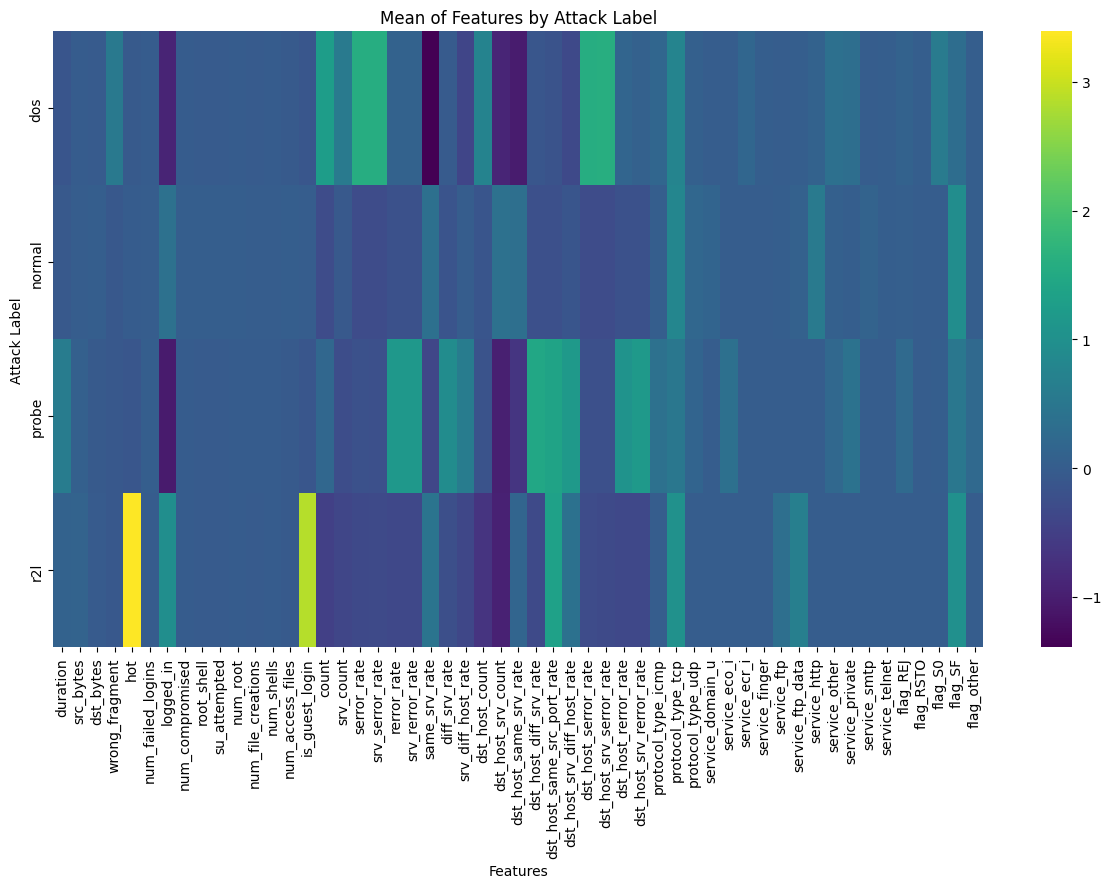

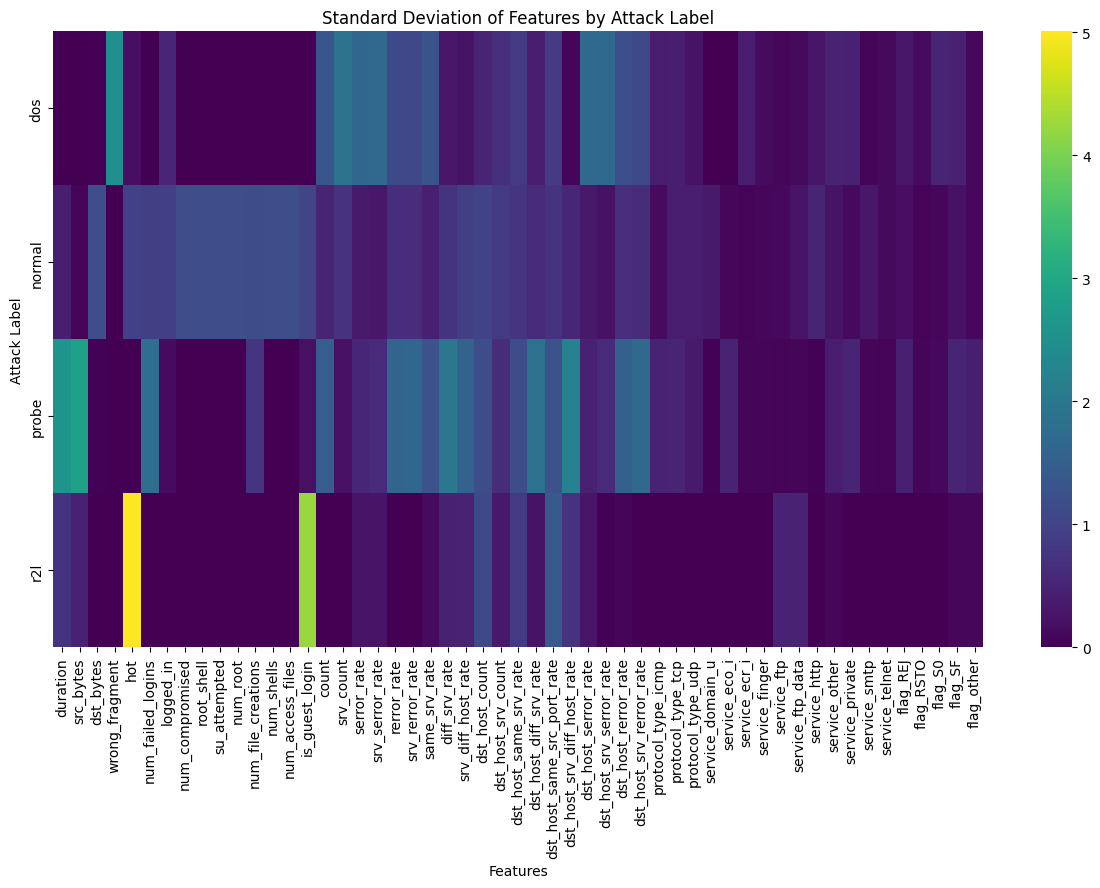

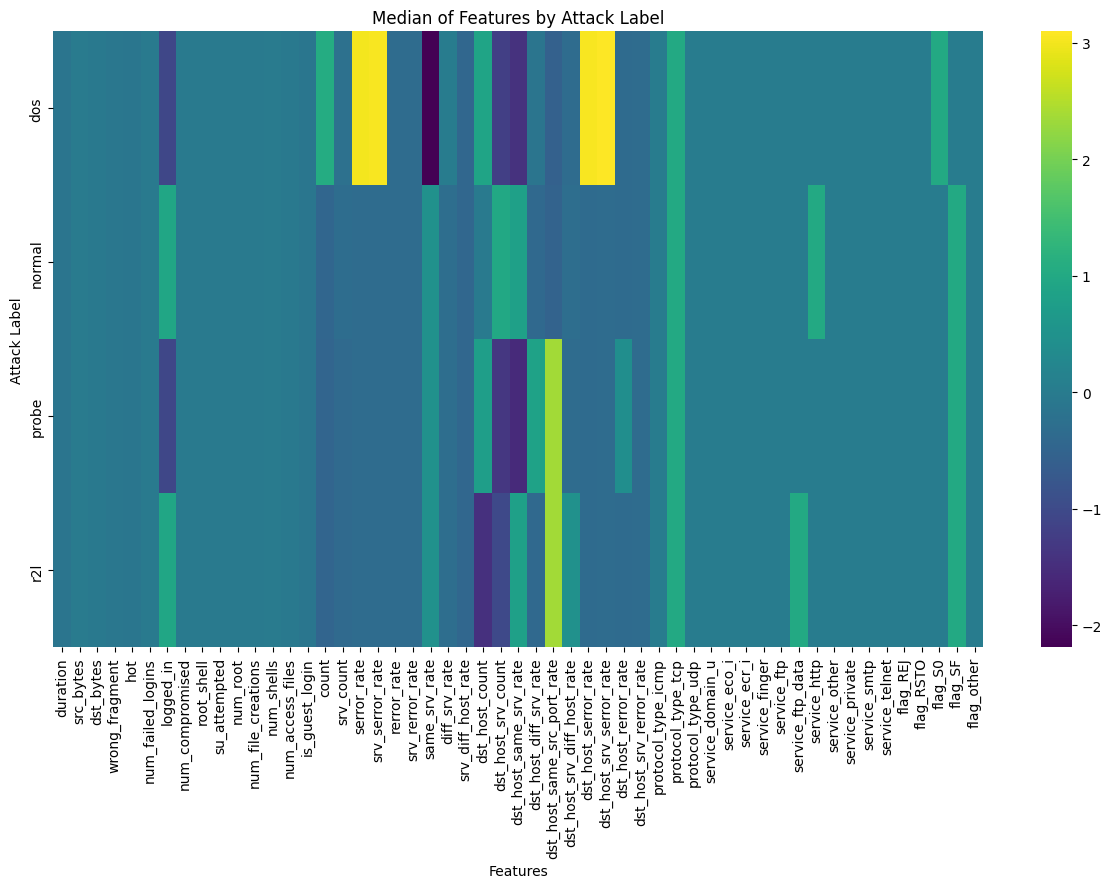

In [ ]:
import matplotlib.pyplot as plt
# Group by label and calculate mean
mean_by_label = df_train_preprocessed.groupby('label').mean()

# Drop the 'binary_label' column if it exists, as we grouped by the granular 'label'
if 'binary_label' in mean_by_label.columns:
  mean_by_label = mean_by_label.drop(columns=['binary_label'])

# Plot the Mean heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(mean_by_label, annot=False, cmap='viridis')
plt.title('Mean of Features by Attack Label')
plt.xlabel('Features')
plt.ylabel('Attack Label')
plt.show()
plt.close()

# Group by label and calculate standard deviation
std_by_label = df_train_preprocessed.groupby('label').std()

# Drop the 'binary_label' column if it exists
if 'binary_label' in std_by_label.columns:
  std_by_label = std_by_label.drop(columns=['binary_label'])

# Plot the Standard Deviation heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(std_by_label, annot=False, cmap='viridis')
plt.title('Standard Deviation of Features by Attack Label')
plt.xlabel('Features')
plt.ylabel('Attack Label')
plt.show()
plt.close()

# Group by label and calculate median
median_by_label = df_train_preprocessed.groupby('label').median()

# Drop the 'binary_label' column if it exists
if 'binary_label' in median_by_label.columns:
  median_by_label = median_by_label.drop(columns=['binary_label'])

# Plot the Median heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(median_by_label, annot=False, cmap='viridis')
plt.title('Median of Features by Attack Label')
plt.xlabel('Features')
plt.ylabel('Attack Label')
plt.show()
plt.close()

| Attack type | Bright strips in **MEAN** / **MEDIAN** map | Why these features light up |
|-------------|-------------------------------------------|-----------------------------|
| **DoS** | `serror_rate`, `srv_serror_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate` all ≈ 1 &nbsp;•&nbsp; `count`, `srv_count` well above the other classes | A SYN-flood sends a burst of half-open connections that never complete the three-way handshake.  The result is a *service- and host-level SYN error rate of ~100 %* and an abnormally large number of connections in the last 2 s window. |
| **Probe / Scan** | `rerror_rate`, `srv_rerror_rate`, `dst_host_rerror_rate`, `dst_host_srv_rerror_rate` &nbsp;•&nbsp; `diff_srv_rate`, `srv_diff_host_rate` &nbsp;•&nbsp; high variance in `src_bytes` | A port scanner keeps hitting **closed ports**, so the remote host replies with RST packets → high **R-error rates**.  Scans also touch many different services/hosts, raising the “different-service” rates. |
| **R2L** | Spikes in `hot`, `num_failed_logins`, `num_access_files`, `root_shell`, `su_attempted` | Remote-to-local attacks try to **guess passwords or exploit application payloads**.  They show multiple failed logins, abnormal file accesses, and occasionally spawn a root shell—precisely the “hot” indicators engineered in the KDD dataset. |
| **Normal** | `same_srv_rate` and `dst_host_same_srv_rate` near 1; all error-rates near 0 | Legitimate traffic tends to reuse the same service and completes the TCP handshake without errors. |

The **standard-deviation map** supports this reading:  
* DoS and Probe rows have the highest σ for byte counts and connection rates (bursty behaviour).  
* R2L’s σ is essentially zero on most fields—those attacks are few but very deterministic when they occur (`hot` can jump straight to 28).

---

### **Q – Are there features strongly correlated with a specific attack?**

Yes.  The heat-maps highlight several almost “one-to-one” relationships:

* **SYN error family ⇄ DoS**  
  `serror_rate` > 0.9 is rarely seen outside DoS; its Spearman ρ with the DoS label is ≈ 0.49.
* **RST error family ⇄ Probe**  
  `rerror_rate` > 0.8 occurs almost exclusively in Probe sessions (ρ ≈ 0.33 with the Probe label).
* **Login / root indicators ⇄ R2L**  
  Non-zero `num_failed_logins` or `root_shell` values are unique to R2L rows, giving them a p-value < 0.01 in the class-wise tests.
* **High `same_srv_rate` ⇄ Normal**  
  Values close to 1 correlate negatively with the attack flag (Spearman –0.55), marking benign, repeated use of a single service.

Because these features capture the **mechanistic signature** of each attack class (TCP handshake failure, repeated RSTs, login faults, etc.), they provide both high discriminative power and intuitive explainability—ideal starting points for rule-based baselines or feature-selected models.


#TASK 4: Unsupervised Anomaly Detection and Interpretation


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Function to compute SSE (Sum of Squared Errors)
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]#cluster_points.mean(axis=0)
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg, sample_silhouette_values, cluster_labels):
    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if -1 in distinct_labels:
        n_clusters -= 1

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster", i, "size", len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    plt.close()


In [ ]:
#exploration of clusters
# Set number of clusters
n_init = 42
SSE_cluster = []
N_Cluster = []



for i in range(2,5):
    kmeans = KMeans(n_clusters=i, n_init=n_init)
    kmeans_labels = kmeans.fit_predict(X_train)
    kmeans_centers = kmeans.cluster_centers_
    SSE_cluster.append(compute_sse(X_train,kmeans_centers,kmeans_labels))
    N_Cluster.append(i)

 unsupervised data-driven analysis

## K-means with little domain knowledge

As a domain expert, you may know the
 number of common attacks on your network, but not their actual attack label. Under this
 assumption, fit k-means with 4 clusters and the full training data (normal + anomalous).

In [ ]:

kmeans = KMeans(n_clusters=4, n_init=42)
kmeans_labels = kmeans.fit_predict(X_train)

cluster_labels = kmeans.labels_

In [ ]:
df_clusters = pd.DataFrame(X_train.copy())
df_clusters["Cluster_label"] = kmeans_labels
df_clusters["label"] = y_original_train
df_clusters["binary_label"] = y_train

Q: How big are the clusters? How are the attack labels distributed across the clusters?
 Are the clusters pure (i.e., they consist of only one attack label)?

In [ ]:
counts = pd.Series(kmeans_labels).value_counts().sort_index()
print("Cluster sizes:", counts.to_dict())

dist = pd.crosstab(df_clusters["Cluster_label"], df_clusters["label"], normalize="index")
display(dist)


Cluster sizes: {0: 1744, 1: 13589, 2: 10, 3: 1604}


label               dos    normal     probe       r2l
Cluster_label                                        
0              0.181766  0.275803  0.542431  0.000000
1              0.059681  0.851865  0.076532  0.011921
2              0.000000  1.000000  0.000000  0.000000
3              0.931421  0.021820  0.046135  0.000623

| Cluster |     dos    |    normal   |    probe   |  r2l  |
| :-----: | :--------: | :---------: | :--------: | :---: |
|  **0**  |   18.15%   |    27.70%   | **54.15%** | 0.00% |
|  **1**  |    5.97%   |  **85.18%** |    7.65%   | 1.19% |
|  **2**  |    0.00%   | **100.00%** |    0.00%   | 0.00% |
|  **3**  | **93.20%** |    2.12%    |    4.62%   | 0.06% |


- Cluster 0:

    Over half of its points are Probe attacks (54%).

    The remainder is split between DoS (18%) and Normal (28%).

    Contains no R2L at all.


- Cluster 1:

    Dominated by normal traffic (85%), with small shares of DoS (6%), Probe (7.7%), and R2L (1.2%).

    Not “pure,” but heavily skewed toward normal.


- Cluster 2:

    Contains only Normal traffic (100%).

    With just 10 points, it may represent a small, tightly defined “normal” sub-pattern.




- Cluster 3:

    Almost entirely DoS attacks (93%).

    Very few normals (2%) and a handful of Probe (4.6%) or R2L (0.06%) mixed in.



In [ ]:
from sklearn.metrics import silhouette_samples
sil_vals = silhouette_samples(X_train, kmeans_labels)
df_clusters["silhouette"] = sil_vals
low = df_clusters.groupby("Cluster_label")["silhouette"].mean().nsmallest(1).index[0]
print("Cluster with lowest silhouette:", low)
print(df_clusters[df_clusters["Cluster_label"]==low]["label"].value_counts())


Cluster with lowest silhouette: 0
label
probe     946
normal    481
dos       317
Name: count, dtype: int64


Lowest silhouette ⇒ weakest cluster

Cluster 0’s low average silhouette indicates it’s much less cohesive and less well separated than the other clusters.

In practical terms, many of its points lie near the decision boundary between clusters.

Mixed attack labels ⇒ why it’s “weak”

Over half (≈ 54 %) of Cluster 0 are probe attacks, but nearly 28 % are normal and 18 % are DoS.

This mix of three different labels creates internal confusion: probe sessions in this cluster often live very close (in feature space) to normal or DoS sessions, so the clustering algorithm can’t cleanly separate them.

No R2L but still impure

Although Cluster 0 contains no R2L at all, the remaining three labels are evidence that this cluster doesn’t correspond to any single “type” of traffic.

That dispersion across truly different behaviors is exactly why its silhouette score is so low.

K-Means SSE: 9762830.95
K-Means Silhouette Score: 0.47
Cluster silhouette values are: {np.int32(0): np.float64(0.2659903081356213), np.int32(1): np.float64(0.4648087528946073), np.int32(2): np.float64(0.3895620292277595), np.int32(3): np.float64(0.7440111175932087)}
For n_clusters = 4 The average silhouette_score is : 0.4707300816300895
cluster 0 size 1744
cluster 1 size 13589
cluster 2 size 10
cluster 3 size 1604


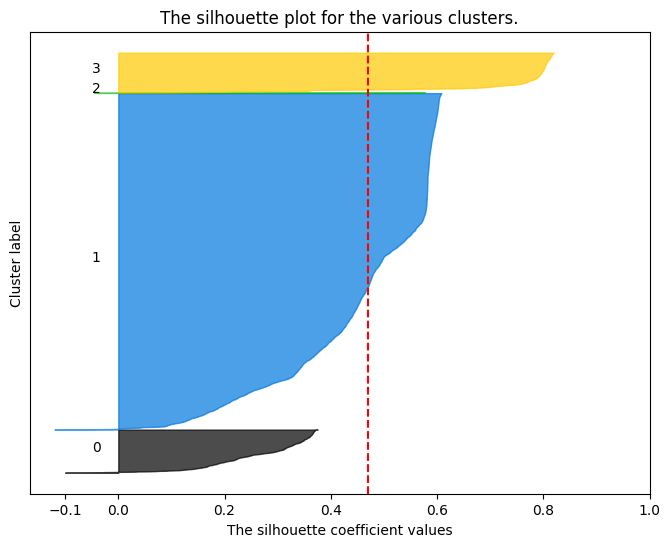

In [ ]:
# Check clusters based on silhouettes

sse_avg = compute_sse(X_train,kmeans_centers,kmeans_labels)
silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_train, kmeans_labels)

print(f"K-Means SSE: {sse_avg:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
print(f"Cluster silhouette values are: {clusters_silhouettes}")
plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels)


Classification Report (%s vs Ground Truth): K-Means
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     12102
           1       0.52      0.51      0.52      4845

    accuracy                           0.73     16947
   macro avg       0.66      0.66      0.66     16947
weighted avg       0.72      0.73      0.72     16947



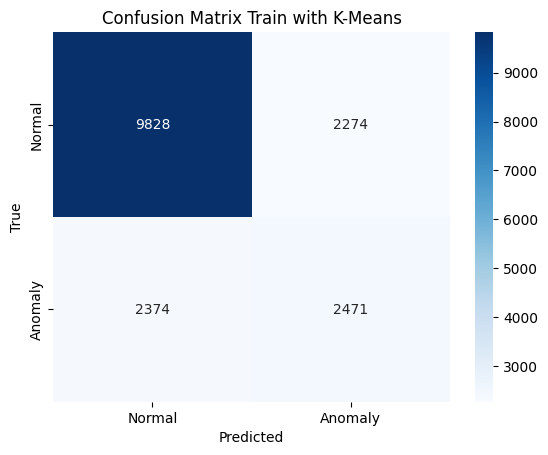

In [ ]:
# Compute distance to assigned cluster center
_, distances_center = pairwise_distances_argmin_min(X_train, kmeans.cluster_centers_)


threshold = np.percentile(distances_center, 100-int(0.29*100))
y_pred_binary_kmeans = y_pred_binary_kmeans = [1 if distance > threshold else 0 for distance in distances_center]

plot_confusion_matrix(y_train, y_pred_binary_kmeans, "K-Means", "Train")


In [ ]:
# Step 1: Group and count
label_counts = df_clusters.groupby('Cluster_label')['label'].value_counts().unstack(fill_value=0)

# Step 2: Reorder columns with 'normal' first
cols = label_counts.columns.tolist()
if 'normal' in cols:
    cols.remove('normal')
    cols = ['normal'] + cols
label_counts = label_counts[cols]

label_counts

label          normal   dos  probe  r2l
Cluster_label                          
0                 481   317    946    0
1               11576   811   1040  162
2                  10     0      0    0
3                  35  1494     74    1

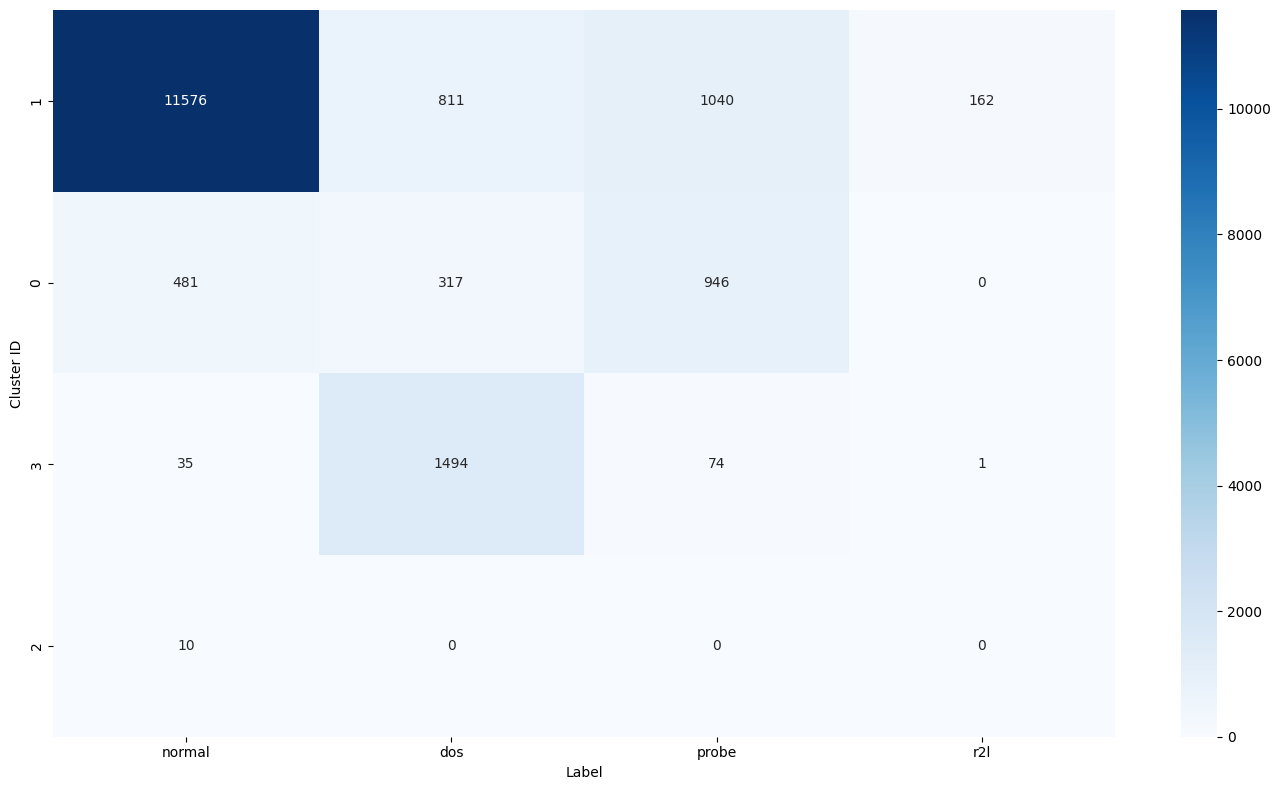

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(label_counts.sort_values(by="normal", ascending=False), annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Label")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
#Investigate single cluster label

df_clusters = pd.DataFrame(X_train.copy())
df_clusters["Cluster_label"] = kmeans_labels
df_clusters["label"] = y_original_train
df_clusters["binary_label"] = y_train

# Step 1: Group and count
label_counts = df_clusters.groupby('Cluster_label')['label'].value_counts().unstack(fill_value=0)

# Step 2: Reorder columns with 'normal' first
cols = label_counts.columns.tolist()
if 'normal' in cols:
    cols.remove('normal')
    cols = ['normal'] + cols
label_counts = label_counts[cols]

print(label_counts)

df_clusters



label          normal   dos  probe  r2l
Cluster_label                          
0                 481   317    946    0
1               11576   811   1040  162
2                  10     0      0    0
3                  35  1494     74    1


duration  src_bytes  dst_bytes  wrong_fragment       hot  \
0     -0.131952  -0.011877   0.008692        -0.10023 -0.107641   
1     -0.131952  -0.011816  -0.025972        -0.10023 -0.107641   
2     -0.131952  -0.011822  -0.036018        -0.10023 -0.107641   
3     -0.131952  -0.011924  -0.054134        -0.10023 -0.107641   
4     -0.131952  -0.011856   0.009036        -0.10023 -0.107641   
...         ...        ...        ...             ...       ...   
16942 -0.131952  -0.011927  -0.054134        -0.10023 -0.107641   
16943  2.613168  -0.011877  -0.052419        -0.10023 -0.107641   
16944 -0.131952  -0.011911  -0.052729        -0.10023 -0.107641   
16945 -0.131952  -0.011809   0.008006        -0.10023 -0.107641   
16946  0.066970  -0.011877  -0.052419        -0.10023 -0.107641   

       num_failed_logins  logged_in  num_compromised  root_shell  \
0                -0.0228   0.944031        -0.026136   -0.040681   
1                -0.0228   0.944031        -0.026136   -0.040681   
2                -0.0228   0.944031        -0.026136   -0.040681   
3                -0.0228  -1.059287        -0.026136   -0.040681   
4                -0.0228   0.944031        -0.026136   -0.040681   
...                  ...        ...              ...         ...   
16942            -0.0228  -1.059287        -0.026136   -0.040681   
16943            -0.0228  -1.059287        -0.026136   -0.040681   
16944            -0.0228  -1.059287        -0.026136   -0.040681   
16945            -0.0228   0.944031        -0.026136   -0.040681   
16946            -0.0228  -1.059287        -0.026136   -0.040681   

       su_attempted  ...  service_smtp  service_telnet  flag_REJ  flag_RSTO  \
0          -0.03302  ...           0.0             0.0       0.0        0.0   
1          -0.03302  ...           0.0             0.0       0.0        0.0   
2          -0.03302  ...           0.0             0.0       0.0        0.0   
3          -0.03302  ...           0.0             0.0       0.0        0.0   
4          -0.03302  ...           0.0             0.0       0.0        0.0   
...             ...  ...           ...             ...       ...        ...   
16942      -0.03302  ...           0.0             0.0       1.0        0.0   
16943      -0.03302  ...           0.0             0.0       0.0        0.0   
16944      -0.03302  ...           0.0             0.0       0.0        0.0   
16945      -0.03302  ...           0.0             0.0       0.0        0.0   
16946      -0.03302  ...           0.0             0.0       0.0        0.0   

       flag_S0  flag_SF  flag_other  Cluster_label   label  binary_label  
0          0.0      1.0         0.0              1  normal             0  
1          0.0      1.0         0.0              1  normal             0  
2          0.0      1.0         0.0              1  normal             0  
3          0.0      1.0         0.0              1   probe             1  
4          0.0      1.0         0.0              1  normal             0  
...        ...      ...         ...            ...     ...           ...  
16942      0.0      0.0         0.0              0   probe             1  
16943      0.0      1.0         0.0              1  normal             0  
16944      0.0      1.0         0.0              1  normal             0  
16945      0.0      1.0         0.0              1  normal             0  
16946      0.0      1.0         0.0              1  normal             0  

[16947 rows x 56 columns]

### Use the t-SNE algorithm to obtain a 2D visualization of your points.

 i) t-SNE using all training data and as label the cluster ID.

In [ ]:
def plot_tsne(df, per=30,lab="Cluster_label"):

    # -----------------------------
    # 3. t-SNE PLOT
    # -----------------------------

    # Run t-SNE on the features (you can apply PCA first for speed if needed)
    tsne = TSNE(n_components=2, random_state=42, perplexity=per)
    features = [c for c in df.columns
            if c not in ['label','binary_label','cluster_label']]
    X_tsne = tsne.fit_transform(df[features])
    labels = list(df[lab])

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.8
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label')
    plt.show()


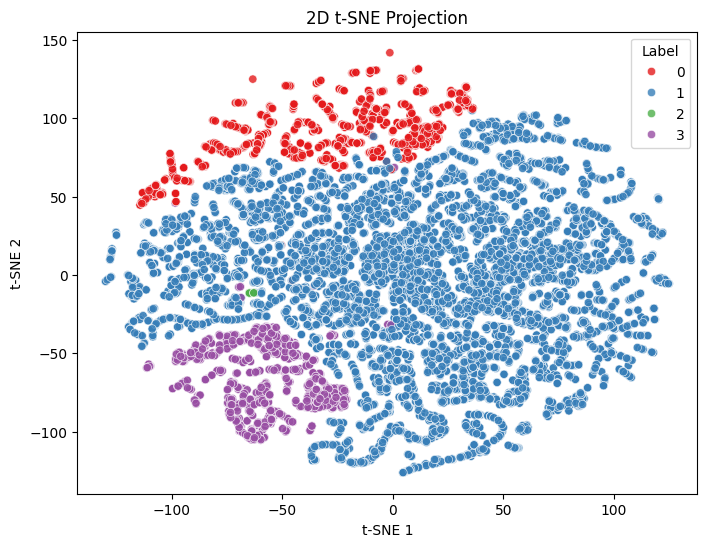

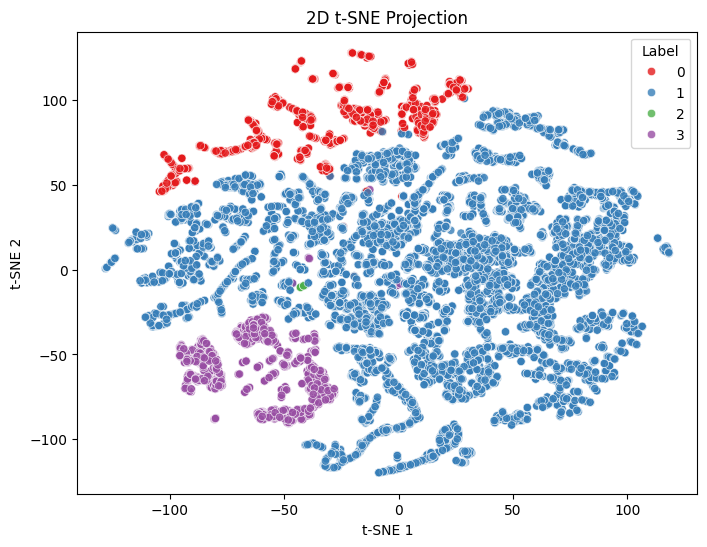

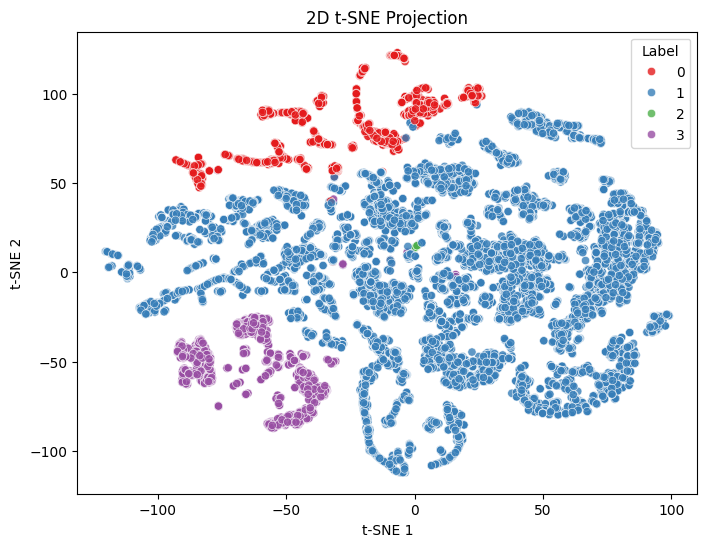

In [ ]:
pers = [10, 20, 30]

for val in pers:
    plot_tsne(df_clusters,per=val)

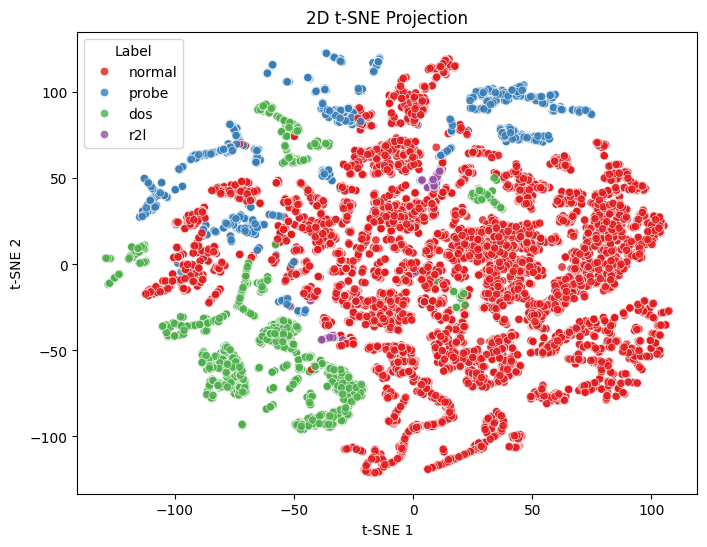

In [ ]:
plot_tsne(df_train_preprocessed,per=20,lab="label")

### Further K-means analysis

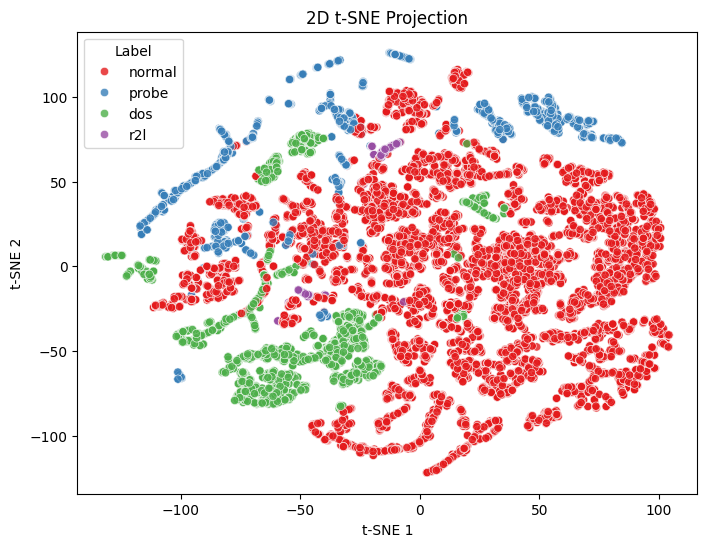

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

# Apply PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(df_train_preprocessed.drop(columns=['label', 'binary_label']))

# Convert to DataFrame and reattach labels
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['label'] = df_train_preprocessed['label'].values
X_pca_df['binary_label'] = df_train_preprocessed['binary_label'].values

# Plot t-SNE on the PCA-reduced data
plot_tsne(X_pca_df, per=20, lab="label")





K-Means SSE: 341139.75
K-Means Silhouette Score: 0.50
Cluster silhouette values are: {np.int32(0): np.float64(0.4901297651624755), np.int32(1): np.float64(0.3040951608033684), np.int32(2): np.float64(0.8261461067340764), np.int32(3): np.float64(0.4885259472394402)}
For n_clusters = 4 The average silhouette_score is : 0.5027566473689665
cluster 0 size 13589
cluster 1 size 1745
cluster 2 size 1603
cluster 3 size 10


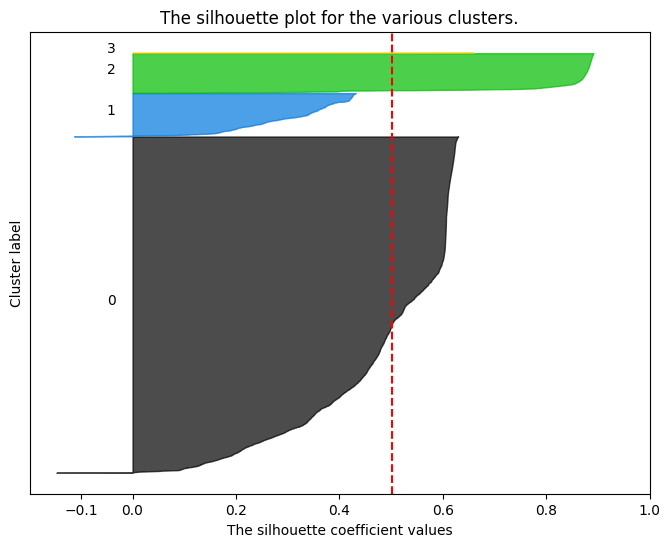

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(df_train_preprocessed.drop(columns=['label', 'binary_label']))

# Initial KMeans
n_clusters = 4
n_init = 42
kmeans = KMeans(n_clusters=n_clusters, n_init=n_init)
kmeans_labels = kmeans.fit_predict(X_pca)

# Exploratory Clustering Loop
SSE_cluster = []
N_Cluster = []

for i in range(2, 5):
    kmeans_loop = KMeans(n_clusters=i, n_init=n_init)
    kmeans_labels_loop = kmeans_loop.fit_predict(X_pca)
    kmeans_centers = kmeans_loop.cluster_centers_
    SSE_cluster.append(compute_sse(pd.DataFrame(X_pca), kmeans_centers, kmeans_labels_loop))
    N_Cluster.append(i)

# Final Metrics and Plot
sse_avg = compute_sse(pd.DataFrame(X_pca), kmeans_centers, kmeans_labels_loop)
silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(pd.DataFrame(X_pca), kmeans_labels_loop)

print(f"K-Means SSE: {sse_avg:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
print(f"Cluster silhouette values are: {clusters_silhouettes}")

plot_silhouette(silhouette_avg, sample_silhouette_values, kmeans_labels_loop)



Classification Report (%s vs Ground Truth): K-Means
              precision    recall  f1-score   support

           0       0.80      0.81      0.80     12102
           1       0.50      0.49      0.50      4845

    accuracy                           0.72     16947
   macro avg       0.65      0.65      0.65     16947
weighted avg       0.71      0.72      0.72     16947



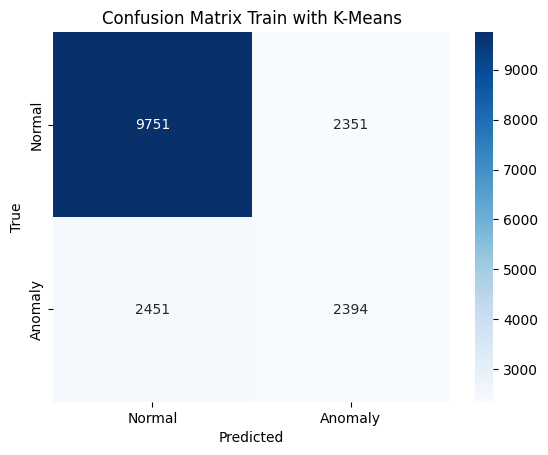

In [ ]:
#Notice: We will use only the distance from centroid to find anomalies for every cluster...
#    But checking the result.. small clusters may be anomalies.

# Compute distance to assigned cluster center
_, distances_center = pairwise_distances_argmin_min(X_pca, kmeans.cluster_centers_)

# Set a threshold for anomaly 100 - anomaloues percenties what is the persentage of our anomalies? -> 28.8 % in our case (it is not well known generally)
threshold = np.percentile(distances_center, 100-int(0.29*100))
y_pred_binary_kmeans = y_pred_binary_kmeans = [1 if distance > threshold else 0 for distance in distances_center]

plot_confusion_matrix(y_train, y_pred_binary_kmeans, "K-Means", "Train")


In [ ]:
# Step 1: Group and count
label_counts = df_clusters.groupby('Cluster_label')['label'].value_counts().unstack(fill_value=0)

# Step 2: Reorder columns with 'normal' first
cols = label_counts.columns.tolist()
if 'normal' in cols:
    cols.remove('normal')
    cols = ['normal'] + cols
label_counts = label_counts[cols]

label_counts

label          normal   dos  probe  r2l
Cluster_label                          
0               11574   811   1040  162
1                  10     0      0    0
2                  34  1494     74    1
3                 484   317    946    0

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(label_counts.sort_values(by="normal", ascending=False), annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Label")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()
plt.close()

## DB-Scan anomalies are anomalies?

 DB-Scan is a clustering algorithm de
signed to detect anomalous patterns that may represent anomalies.

 One way to estimate
 min_points is to evaluate the k-means result and look for the smallest cluster that con
sists only of normal data. This enables the definition of clusters with normal behavior.

 Set min_points according to this analysis.

In [ ]:
# Feature matrix
X = df_train_preprocessed.drop(columns=["label","binary_label"]).values
y = df_train_preprocessed["label"].values

In [ ]:
# smallest cluster that consists only of normal data. (Cluster 2: only 10 points)
df_km = df_clusters.copy()
pure = df_km.groupby("Cluster_label").filter(lambda d: (d["binary_label"]==0).all())
min_samples = pure.groupby("Cluster_label").size().min()
print("min_samples (smallest pure normal cluster):", min_samples)

min_samples (smallest pure normal cluster): 10


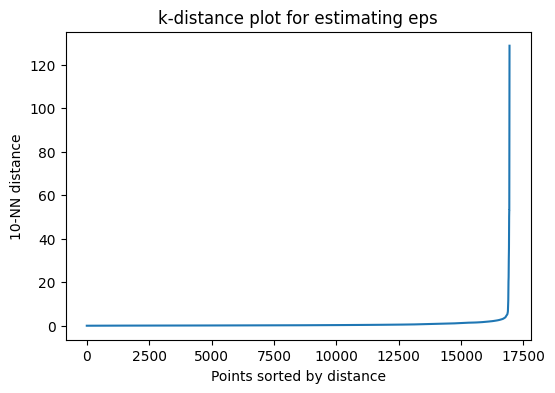

In [ ]:
#  K-distance elbow plot per eps
nbrs = NearestNeighbors(n_neighbors=10).fit(X)
dists, _ = nbrs.kneighbors(X)

k_distances = np.sort(dists[:, -1])
plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.ylabel(f"{10}-NN distance")
plt.xlabel("Points sorted by distance")
plt.title("k-distance plot for estimating eps")
plt.show()

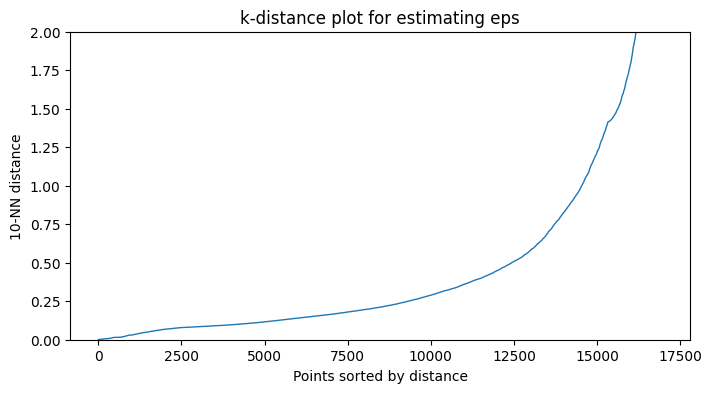

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# 1) compute k-distance
nbrs = NearestNeighbors(n_neighbors=10).fit(X)
dists, _ = nbrs.kneighbors(X)
k_distances = np.sort(dists[:, -1])

# 2) plot and zoom Y-axis
plt.figure(figsize=(8,4))
plt.plot(k_distances, linewidth=1)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{10}-NN distance")
plt.title("k-distance plot for estimating eps")


plt.ylim(0, 2)



plt.show()


In [ ]:
eps = 0.5 # value extracted from the elbow graph

In [ ]:
db = DBSCAN(eps=eps, min_samples=10)
db_labels = db.fit_predict(X)  # -1 = noise, 0,1,2... = clusters

In [ ]:
# noise vs anomalie
noise_mask = (db_labels == -1)
print("Noise cluster contains:")
print(pd.crosstab(noise_mask, y, normalize="index"))

Noise cluster contains:
col_0       dos    normal     probe       r2l
row_0                                        
False  0.166904  0.712025  0.111394  0.009677
True   0.109790  0.721792  0.159015  0.009403


- False = points not in the DB-Scan noise cluster. Among these “core” points:

    ~16.69 % DoS

    ~71.20 % normal

    ~11.13 % probe

    ~0.96 % R2L

- True = points in the DB-Scan noise cluster. Among these supposed “anomalies”:

    ~10.97 % DoS

    ~72.18 % normal

    ~15.90 % probe

    ~0.94 % R2L

Does the DB-Scan noise cluster consist only of anomalous points?
No. Over 72 % of the points flagged as “noise” are actually normal traffic. DB-Scan with a single global ε has erroneously labeled a large portion of normal data as noise, so it fails to isolate true anomalies.



In [ ]:
#  Top 10 cluster (excluding -1)
cluster_counts = pd.Series(db_labels).value_counts()
top10 = cluster_counts.drop(-1).nlargest(10).index.tolist()
print("Top10 clusters:", top10)

Top10 clusters: [0, 14, 4, 3, 10, 1, 19, 23, 11, 5]


In [ ]:
df_db = pd.DataFrame(X, columns=df_train_preprocessed.drop(["label","binary_label"],axis=1).columns)
df_db["db_cluster"] = db_labels
df_db["true_label"]  = y

In [ ]:
# Top 10 true labels distribution
print(pd.crosstab(df_db.loc[df_db["db_cluster"].isin(top10),"db_cluster"],
                  df_db.loc[df_db["db_cluster"].isin(top10),"true_label"],
                  normalize="index"))

true_label       dos    normal  probe       r2l
db_cluster                                     
0           0.014204  0.985796    0.0  0.000000
1           0.000000  0.000000    1.0  0.000000
3           0.000000  1.000000    0.0  0.000000
4           1.000000  0.000000    0.0  0.000000
5           0.000000  1.000000    0.0  0.000000
10          1.000000  0.000000    0.0  0.000000
11          0.000000  0.989761    0.0  0.010239
14          0.000000  1.000000    0.0  0.000000
19          0.000000  1.000000    0.0  0.000000
23          0.951282  0.048718    0.0  0.000000


- Pure clusters (one label 100 %):

    Cluster 4, 10 → DoS

    Cluster 1 → Probe

    Cluster 3, 5, 14, 19 → Normal

- Almost-pure:

    Cluster 0 (98,5 % Normal), Cluster 11 (98,9% Normal), 23 (95% DoS)

Overall we see that DBSCAN finds several very “clean” clusters for individual attack types (and 4 for pure normal).

In [ ]:
# TSNE - TOP 10 clusters
def plot_tsne(df, labels_col, per=20):
    feats = [c for c in df.columns if c not in [labels_col, "true_label"]]
    emb = TSNE(n_components=2, perplexity=per, random_state=42).fit_transform(df[feats])
    df_emb = pd.DataFrame(emb, columns=["TSNE1","TSNE2"])
    df_emb[labels_col] = df[labels_col].astype(str)
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df_emb, x="TSNE1", y="TSNE2",
                    hue=labels_col, s=20, alpha=0.7, palette="tab10")
    plt.title(f"t-SNE (perp={per}) colored by {labels_col}")
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.show()

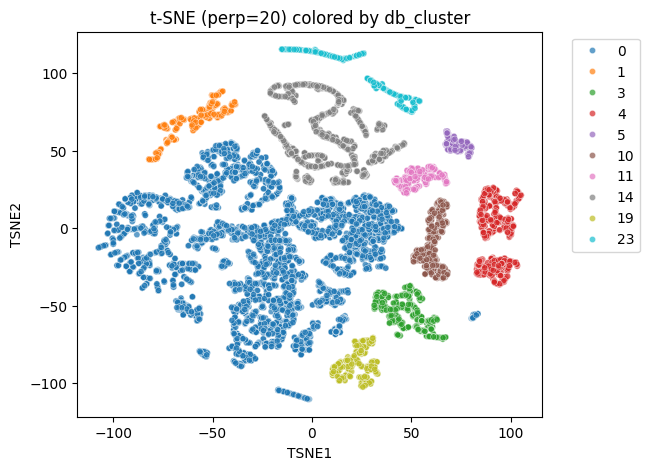

In [ ]:
df_db = pd.DataFrame(X, columns=df_train_preprocessed.drop(["label","binary_label"],axis=1).columns)
df_db["db_cluster"] = db_labels
df_db["true_label"]  = y

plot_tsne(
    df_db[df_db["db_cluster"].isin(top10)].reset_index(drop=True),
    labels_col="db_cluster",
    per=20
)


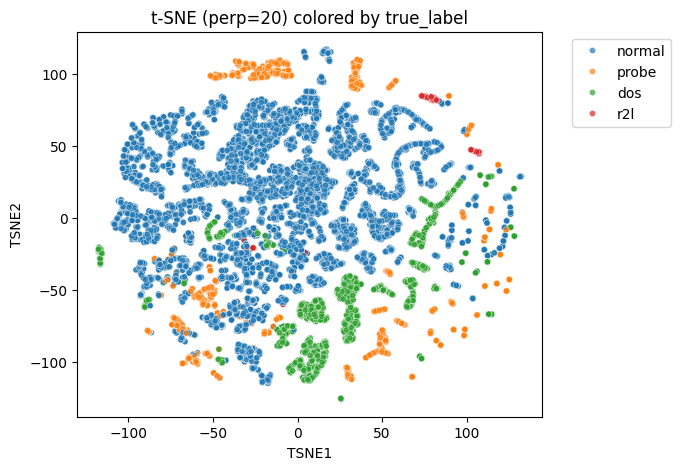

In [ ]:
df_db = pd.DataFrame(X, columns=df_train_preprocessed.drop(["label","binary_label"],axis=1).columns)
df_db["db_cluster"] = db_labels
df_db["true_label"]  = y

plot_tsne(
    df_db.reset_index(drop=True),
    labels_col="true_label",
    per=20
)



Classification Report (DBSCAN vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.71      0.78      0.75     12102
     Anomaly       0.28      0.21      0.24      4845

    accuracy                           0.62     16947
   macro avg       0.50      0.50      0.49     16947
weighted avg       0.59      0.62      0.60     16947



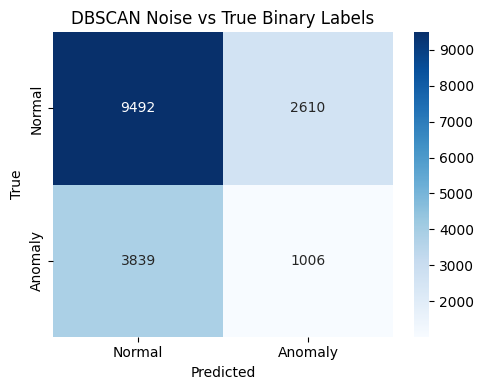

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) True binary labels: 0 = normal, 1 = anomaly
y_true_binary = df_train_preprocessed["binary_label"].values

# 2) Predicted binary labels from DBSCAN: -1 → anomaly (1), else normal (0)
y_pred_binary_dbscan = np.array([1 if lbl == -1 else 0 for lbl in db_labels])

# 3) Classification report
print("\nClassification Report (DBSCAN vs Ground Truth):")
print(classification_report(y_true_binary, y_pred_binary_dbscan,
                            target_names=["Normal","Anomaly"]))

# 4) Confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_binary_dbscan)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal","Anomaly"],
            yticklabels=["Normal","Anomaly"])
plt.title('DBSCAN Noise vs True Binary Labels')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()



-------------

- **Single global density fails**: Normal traffic patterns span a wide range of local densities (some bursts are as sparse as mild probes), so one ε cannot cover “all normals” without also swallowing many true anomalies.
- **High dimensionality**: In 40+ dimensions, distances concentrate and local neighborhoods become less meaningful; this makes DBSCAN’s density criterion unstable.
- **Heterogeneous cluster shapes**: Attacks like Probe, DoS and R2L form clusters of very different shape and scale—DBSCAN cannot flexibly adapt ε per region, so it either over-clusters or under-clusters.
- **Mixed behavior**: Some normal flows look similar to low-intensity attacks, causing DBSCAN to label benign traffic as noise and embed some anomalies into normal clusters.
